# 11. Variational Auto-Encoder

_Exercise: Train a variational autoencoder on the image dataset of your choice, and use it to generate images. Alternatively, you can try to find an unlabeled dataset that you are interested in and see if you can generate new samples._

## Prepare environment

In [1]:
import os

import tensorflow as tf

import keras
from keras import (
    layers,
    datasets,
    metrics,
    optimizers,
    callbacks,
    Model,
    losses,
    Sequential,
    Input
)
import keras_tuner as kt

import numpy as np

from matplotlib import pyplot as plt

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score, silhouette_score

from skimage.metrics import structural_similarity

from collections import Counter

import json

import pandas as pd

from scipy import stats

np.random.seed(42)
tf.random.set_seed(42)

# Set the seed using keras.utils.set_random_seed. This will set:
# 1) `numpy` seed
# 2) backend random seed
# 3) `python` random seed
keras.utils.set_random_seed(42)

# If using TensorFlow, this will make GPU ops as deterministic as possible,
# but it will affect the overall performance, so be mindful of that.
tf.config.experimental.enable_op_determinism()

2025-04-12 13:24:17.241402: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744457057.260562  169290 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744457057.267416  169290 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-04-12 13:24:17.287548: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
IMG_WIDTH = 28
IMG_HEIGHT = 28
IMG_CHANNELS = 1
INPUT_SHAPE = (IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)
FLAT_SHAPE = IMG_HEIGHT * IMG_WIDTH

### Hyperparameters

In [3]:
EPOCHS = 100
EARLY_STOPPING_PATIENCE = 10
BATCH_SIZE = 128
OPTIMIZER = "adam"

In [ ]:
LATENT_DIM_OPTIONS = [10, 20]
KL_WEIGHT_OPTIONS = [1.0] # KL_Weight in HP tuning needs to be fixed because otherwise tuner when optimizing for total_loss chooses minimum value
LEARNING_RATE_OPTIONS = [1e-3, 5e-4, 1e-4]

### Prepare logs

In [ ]:
PARENT_LOGS_PATH = "logs"
ITERATION = 35

current_logs_path = os.path.join(PARENT_LOGS_PATH, str(ITERATION))
os.makedirs(current_logs_path, exist_ok=True)
print(current_logs_path)

logs = {
    "iteration" : ITERATION,
    "summary" : "Add Batch Normalization"
}

logs/99


In [6]:
logs["EPOCHS"] = EPOCHS
logs["EARLY_STOPPING_PATIENCE"] = EARLY_STOPPING_PATIENCE
logs["BATCH_SIZE"] = BATCH_SIZE
logs["OPTIMIZER"] = OPTIMIZER

## Prepare dataset

In [7]:
def preprocess(array):
    """Normalize and reshape images."""
    array = array.astype("float32") / 255.0
    array = np.reshape(array, (len(array), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    return array

def deprocess(array):
    """Denormalize images."""
    array = np.reshape(array, (len(array), IMG_HEIGHT, IMG_WIDTH))
    array = array * 255.0
    array = array.astype("uint8")
    return array

In [8]:
(x_train, y_train), (x_test, y_test) = datasets.mnist.load_data()

x_train = preprocess(x_train)
x_test = preprocess(x_test)

print(f"x_train shape: {x_train.shape}")
print(f"x_test shape: {x_test.shape}")

x_train shape: (60000, 28, 28, 1)
x_test shape: (10000, 28, 28, 1)


### Check if dataset is not evenly distributed

In [9]:
class_distribution = Counter(y_train)
print(class_distribution)

norm_labels_distr = {k: v / len(y_train) for k, v in class_distribution.items()}
print(norm_labels_distr)

def gini_coefficient(probabilities):
    probabilities = np.sort(probabilities)
    n = len(probabilities)
    index = np.arange(1, n + 1)
    return (np.sum((2 * index - n - 1) * probabilities)) / (n * np.sum(probabilities))

gini = gini_coefficient(list(norm_labels_distr.values()))
print(f"Gini coefficient for class distribution of train images: {gini}")

Counter({1: 6742, 7: 6265, 3: 6131, 2: 5958, 9: 5949, 0: 5923, 6: 5918, 8: 5851, 4: 5842, 5: 5421})
{5: 0.09035, 0: 0.09871666666666666, 4: 0.09736666666666667, 1: 0.11236666666666667, 9: 0.09915, 2: 0.0993, 3: 0.10218333333333333, 6: 0.09863333333333334, 7: 0.10441666666666667, 8: 0.09751666666666667}
Gini coefficient for class distribution of train images: 0.027326666666666676


## Train Variational Auto-Encoder

In [10]:
class Sampling(layers.Layer):
    def call(self, inputs):
        mean, log_var = inputs
        return tf.random.normal(tf.shape(log_var)) * tf.exp(log_var / 2) + mean 

### Encoder

In [ ]:
def build_encoder(latent_dim):
    encoder_inputs = Input(shape=INPUT_SHAPE, name="encoder_input")
    Z = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
    Z = layers.BatchNormalization()(Z)
    Z = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(Z)
    Z = layers.BatchNormalization()(Z)
    Z = layers.Flatten()(Z)
    # Intermediate dense layer
    Z = layers.Dense(16, activation="relu")(Z)
    # Latent space parameters
    codings_mean = layers.Dense(latent_dim, name="z_mean")(Z)
    codings_log_var = layers.Dense(latent_dim, name="z_log_var")(Z)
    codings = Sampling()([codings_mean, codings_log_var])
    # Instantiate Encoder model (useful separately)
    variational_encoder = Model(
        inputs=encoder_inputs, outputs=[codings_mean, codings_log_var, codings], name="encoder")
    return variational_encoder

### Decoder

In [ ]:
def build_decoder(latent_dim):
    decoder_inputs = Input(shape=(latent_dim,), name="decoder_input")
    # Map latent vector back to the shape before Flatten in encoder
    # The shape before Flatten was (7, 7, 64) because 28 -> 14 (stride 2) -> 7 (stride 2)
    Z = layers.Dense(7 * 7 * 64, activation="relu")(decoder_inputs)
    Z = layers.Reshape((7, 7, 64))(Z)
    # Use Conv2DTranspose (deconvolution) to upsample
    Z = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(Z)
    Z = layers.BatchNormalization()(Z)
    Z = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(Z)
    Z = layers.BatchNormalization()(Z)
    # Final layer to reconstruct the image
    decoder_outputs = layers.Conv2DTranspose(IMG_CHANNELS, 3, activation="sigmoid", padding="same", name="decoder_output")(Z)
    # Instantiate Decoder model (useful separately for generation)
    variational_decoder = Model(decoder_inputs, decoder_outputs, name="decoder")
    return variational_decoder

### Loss layer

In [ ]:
class VAELossLayer(layers.Layer):
    def __init__(self, beta, **kwargs):
        super(VAELossLayer, self).__init__(**kwargs)
        self.beta = beta
        self.reconstruction_loss_tracker = metrics.Mean(name="reconstruction_loss")
        self.kl_loss_tracker = metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def call(self, inputs, codings_mean, codings_log_var, reconstructions):
        # 1. Reconstruction Loss
        reconstruction_loss = tf.reduce_mean(
            losses.binary_crossentropy(
                tf.reshape(inputs, [-1, FLAT_SHAPE]),
                tf.reshape(reconstructions, [-1, FLAT_SHAPE]),
            )
        )
        reconstruction_loss *= tf.cast(tf.reduce_prod(inputs.shape[1:]), tf.float32) # Scale for pixel-wise loss
        
        # 2. KL Divergence Loss
        kl_loss = -0.5 * tf.reduce_sum(
            1 + codings_log_var - tf.square(codings_mean) - tf.exp(codings_log_var),
            axis=-1
        )
        kl_loss = tf.reduce_mean(kl_loss)  # Average over the batch

        # 3. Total VAE Loss
        total_loss = reconstruction_loss + self.beta * kl_loss

        # Add the total loss to the model
        self.add_loss(total_loss)

        # Add loss values to metrics for monitoring
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)

        return reconstructions

### Variational Auto-Encoder

In [14]:
def build_vae(hyperparams):
    hp_latent_dims = hyperparams.Choice("latent_dim", LATENT_DIM_OPTIONS)
    variational_encoder = build_encoder(hp_latent_dims)
    encoder_inputs = variational_encoder.input
    variational_decoder = build_decoder(hp_latent_dims)

    # Get the output of the decoder by passing the sampled `z` from the encoder
    codings_mean, codings_log_var, codings = variational_encoder(encoder_inputs)
    reconstructions = variational_decoder(codings)
    
    hp_kl_weight = hyperparams.Choice("kl_weight", KL_WEIGHT_OPTIONS)
    outputs = VAELossLayer(beta=hp_kl_weight)(
        encoder_inputs, codings_mean, codings_log_var, reconstructions
    )

    variational_ae = Model(inputs=encoder_inputs, outputs=outputs)
    hp_learning_rate = hyperparams.Choice("learning_rate", LEARNING_RATE_OPTIONS)
    variational_ae.compile(optimizer=optimizers.Adam(learning_rate=hp_learning_rate))

    return variational_ae

### Training

In [15]:
tuner = kt.Hyperband(
    build_vae,
    objective="val_loss",
    max_epochs=EPOCHS,
    directory="hp_tuning",
    project_name="vae_exercise",
)

early_stopping_cb = callbacks.EarlyStopping(
    patience=EARLY_STOPPING_PATIENCE, restore_best_weights=True, mode="min"
)

reduce_lr_cb = callbacks.ReduceLROnPlateau(
    monitor="val_loss", factor=0.5, patience=5, min_lr=1e-6, min_delta=0.3
)

tuner.search(
    x_train,
    x_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(x_test, x_test),
    callbacks=[early_stopping_cb, reduce_lr_cb],
)

# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(best_hps.get_config())

LATENT_DIM = best_hps.get("latent_dim")
KL_WEIGHT = best_hps.get("kl_weight")
LEARNING_RATE = best_hps.get("learning_rate")

logs["LATENT_DIM"] = LATENT_DIM
logs["KL_WEIGHT"] = KL_WEIGHT
logs["LEARNING_RATE"] = LEARNING_RATE

Trial 9 Complete [00h 00m 47s]
val_loss: 198.03530883789062

Best val_loss So Far: 156.62356567382812
Total elapsed time: 00h 07m 02s
{'space': [{'class_name': 'Choice', 'config': {'name': 'latent_dim', 'default': 8, 'conditions': [], 'values': [8, 16, 32], 'ordered': True}}, {'class_name': 'Choice', 'config': {'name': 'kl_weight', 'default': 2.0, 'conditions': [], 'values': [2.0], 'ordered': True}}, {'class_name': 'Choice', 'config': {'name': 'learning_rate', 'default': 0.001, 'conditions': [], 'values': [0.001, 0.0005, 0.0001], 'ordered': True}}], 'values': {'latent_dim': 16, 'kl_weight': 2.0, 'learning_rate': 0.0005, 'tuner/epochs': 2, 'tuner/initial_epoch': 0, 'tuner/bracket': 4, 'tuner/round': 0}}


In [16]:
# Build the model with the optimal hyperparameters and train it on the data for 100 epochs
model = build_vae(best_hps)
history = model.fit(
    x_train,
    x_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(x_test, x_test),
    callbacks=[early_stopping_cb, reduce_lr_cb],
)

best_epoch = early_stopping_cb.best_epoch
print(f"Best epoch: {best_epoch + 1}")

best_loss = history.history["val_loss"][best_epoch]
best_reconstruction_loss = history.history["val_reconstruction_loss"][best_epoch]
best_kl_loss = history.history["val_kl_loss"][best_epoch]

print(f"Best total loss: {best_loss}, reconstruction loss: {best_reconstruction_loss}, kl_loss: {best_kl_loss}")

logs["LOSS"] = best_loss
logs["RECONSTRUCTION"] = best_reconstruction_loss
logs["KL"] = best_kl_loss

Epoch 1/100


2025-04-12 13:31:25.698963: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


468/469 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - kl_loss: 3.6330 - loss: 275.9038 - reconstruction_loss: 268.6376

2025-04-12 13:31:48.970920: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


469/469 ━━━━━━━━━━━━━━━━━━━━ 25s 48ms/step - kl_loss: 3.6371 - loss: 275.6572 - reconstruction_loss: 268.3827 - val_kl_loss: 8.2299 - val_loss: 171.2328 - val_reconstruction_loss: 154.8649 - learning_rate: 5.0000e-04
Epoch 2/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 20s 43ms/step - kl_loss: 9.9952 - loss: 161.9887 - reconstruction_loss: 141.9983 - val_kl_loss: 12.0191 - val_loss: 145.3900 - val_reconstruction_loss: 121.3084 - learning_rate: 5.0000e-04
Epoch 3/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 22s 46ms/step - kl_loss: 12.4783 - loss: 144.0279 - reconstruction_loss: 119.0713 - val_kl_loss: 12.9279 - val_loss: 136.4442 - val_reconstruction_loss: 110.5245 - learning_rate: 5.0000e-04
Epoch 4/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 23s 49ms/step - kl_loss: 13.2150 - loss: 136.1843 - reconstruction_loss: 109.7542 - val_kl_loss: 13.8484 - val_loss: 131.8527 - val_reconstruction_loss: 104.0553 - learning_rate: 5.0000e-04
Epoch 5/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 21s 45ms/step - kl_loss: 13.5381 - loss: 132.0543 

## Evaluation

In [17]:
variational_ae = model
variational_encoder = model.get_layer(name="encoder")
variational_decoder = model.get_layer(name="decoder")

### Learning curves

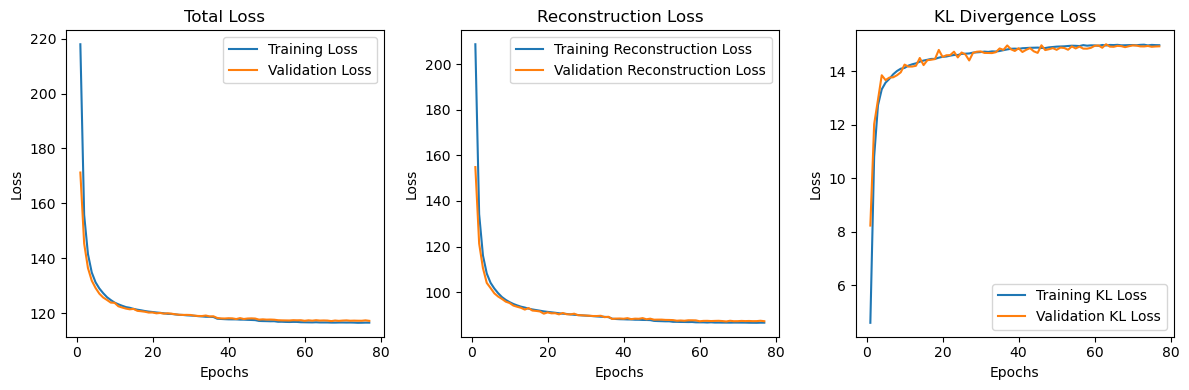

In [18]:
# Plotting the losses after training
total_loss = history.history['loss']
reconstruction_loss = history.history['reconstruction_loss']
kl_loss = history.history['kl_loss']
val_loss = history.history.get('val_loss')
val_reconstruction_loss = history.history.get('val_reconstruction_loss')
val_kl_loss = history.history.get('val_kl_loss')

epochs_range = range(1, len(total_loss) + 1)

plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.plot(epochs_range, total_loss, label='Training Loss')
if val_loss:
    plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.title('Total Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(epochs_range, reconstruction_loss, label='Training Reconstruction Loss')
if val_reconstruction_loss:
    plt.plot(epochs_range, val_reconstruction_loss, label='Validation Reconstruction Loss')
plt.title('Reconstruction Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(epochs_range, kl_loss, label='Training KL Loss')
if val_kl_loss:
    plt.plot(epochs_range, val_kl_loss, label='Validation KL Loss')
plt.title('KL Divergence Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.savefig(os.path.join(current_logs_path, "learning_curves.png"))
plt.show()

### Train a very basic classifier on real MNIST data

It will help us with evaluating reconstructed and generated images.

In [19]:
def build_simple_classifier():
    classifier = Sequential(
        [
            layers.Input(shape=INPUT_SHAPE),
            layers.Flatten(),
            layers.Dense(64, activation="relu"),
            layers.Dense(10, activation="softmax"),  # 10 classes for MNIST digits
        ]
    )
    classifier.compile(
        optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"]
    )
    return classifier


classifier = build_simple_classifier()
# Train on a subset (with more data accuracy/confidence is high even for not that clear images)
classifier.fit(x_train[:10000], y_train[:10000], epochs=5, batch_size=128, verbose=0)

2025-04-12 13:59:42.523526: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


### Reconstructions

#### Mean Squared Error

In [20]:
print("\nEvaluating Reconstruction Quality...")
reconstructed_sample = variational_ae.predict(x_test)

# Calculate Reconstruction Error (Proxy for visual quality)
reconstruction_mse = np.mean((x_test - reconstructed_sample)**2)
print(f"Mean Squared Error (MSE) on {len(x_test)} test samples: {reconstruction_mse:.6f}")
# Lower MSE generally means better reconstruction fidelity.
logs["MSE"] = reconstruction_mse


Evaluating Reconstruction Quality...


2025-04-12 13:59:48.691556: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step
Mean Squared Error (MSE) on 10000 test samples: 0.016367


#### Mean True Confidence

How big of a confidence we get when predicting true labels on reconstructed images.

In [21]:
predictions = classifier.predict(reconstructed_sample)
true_confidence = [pred[y] for pred, y in zip(predictions, y_test)]
mean_true_confidence = np.mean(true_confidence)
print(f"Mean confidence of true labels on reconstructed images: {mean_true_confidence}")
logs["MTC"] = mean_true_confidence

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Mean confidence of true labels on reconstructed images: 0.8515406250953674


#### Mean Structural Similarity Index Measure (SSIM)

In [22]:
print("\nEvaluating the structural similarity index measure (SSIM)...")

ssim_scores = []
for i in range(len(x_test)):
    ssim = structural_similarity(x_test[i], reconstructed_sample[i], data_range=1, win_size=7, channel_axis=-1)
    ssim_scores.append(ssim)
mean_ssim = np.mean(ssim_scores)
print(f"The mean structural similarity index measure (SSIM) on {len(x_test)} test samples: {mean_ssim}")
logs["MSSIM"] = mean_ssim


Evaluating the structural similarity index measure (SSIM)...
The mean structural similarity index measure (SSIM) on 10000 test samples: 0.8165770769119263


#### Peak Signal-to-Noise Ratio (PSNR)

Make sure that both input and output are normalized to (0,1), since we specify max_val as 1.0.

E.g. without Sigmoid function, output was exceeding these bounds.

- High PSNR (e.g., 40 dB or more)
- Good PSNR (e.g., 30-40 dB)
- Fair PSNR (e.g., 20-30 dB)
- Low PSNR (e.g., below 20 dB)

In [23]:
max_value = np.max(x_test)
min_value = np.min(x_test)

print(f"Max value: {max_value}")
print(f"Min value: {min_value}")

Max value: 1.0
Min value: 0.0


In [24]:
max_value = np.max(reconstructed_sample)
min_value = np.min(reconstructed_sample)

print(f"Max value: {max_value}")
print(f"Min value: {min_value}")

Max value: 0.9992126226425171
Min value: 0.0


In [25]:
# In case reconstructed sample exceeds (0, 1) bounds
cliped_reconstructed_sample = np.clip(reconstructed_sample, 0, 1)

psnr = np.mean(tf.image.psnr(x_test, cliped_reconstructed_sample, max_val=1.0).numpy())
print(f"Peak Signal-to-Noise Ratio (PSNR) on {len(x_test)} test samples: {psnr}")
logs["PSNR"] = psnr

Peak Signal-to-Noise Ratio (PSNR) on 10000 test samples: 18.446725845336914


#### Plot reconstructions for visual inspection

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


2025-04-12 13:59:55.298968: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


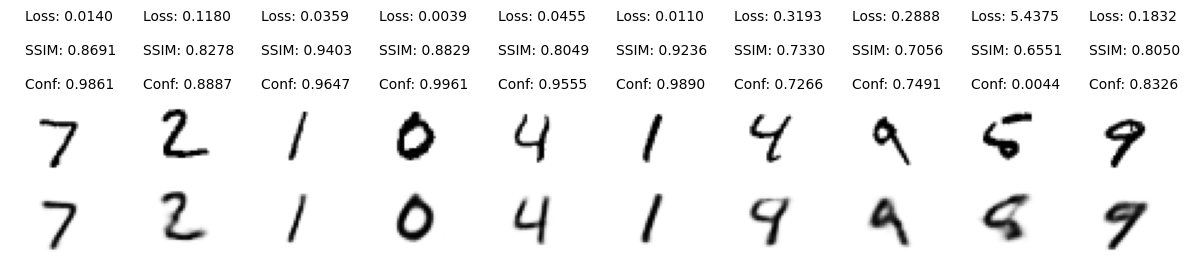

In [26]:
def plot_reconstructions(model, images, labels, n_images=10):
    reconstructions = np.clip(model.predict(images[:n_images]), 0, 1)
    fig = plt.figure(figsize=(n_images * 1.5, 3))
    for image_index in range(n_images):

        plt.subplot(3, n_images, 1 + image_index)
        sample_prediction = classifier.predict(np.expand_dims(reconstructions[image_index], axis=0))
        sample_confidence = sample_prediction[0][labels[image_index]]
        plt.text(0.15, 0, "Conf: {:.4f}".format(sample_confidence))

        sample_ssmi = structural_similarity(images[image_index], reconstructions[image_index], data_range=1, channel_axis=-1)
        plt.text(0.15, 0.5, "SSIM: {:.4f}".format(sample_ssmi))

        sample_loss, _ = classifier.evaluate(
            np.expand_dims(reconstructions[image_index], axis=0),
            np.expand_dims(labels[image_index], axis=0),
            verbose=0
        )
        plt.text(0.15, 1.0, "Loss: {:.4f}".format(sample_loss))
        plt.axis("off")

        plt.subplot(3, n_images, 1 + n_images + image_index)
        plt.imshow(images[image_index], cmap="binary")
        plt.axis("off")

        plt.subplot(3, n_images, 1 + 2 * n_images + image_index)
        plt.imshow(reconstructions[image_index], cmap="binary")
        plt.axis("off")

plot_reconstructions(variational_ae, images=x_test, labels=y_test)
plt.savefig(os.path.join(current_logs_path, "reconstructions.png"))
plt.show()

#### Per-Class Reconstruction

Analyze which digits reconstruct well vs. poorly

2025-04-12 14:00:00.556655: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-04-12 14:00:05.790560: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

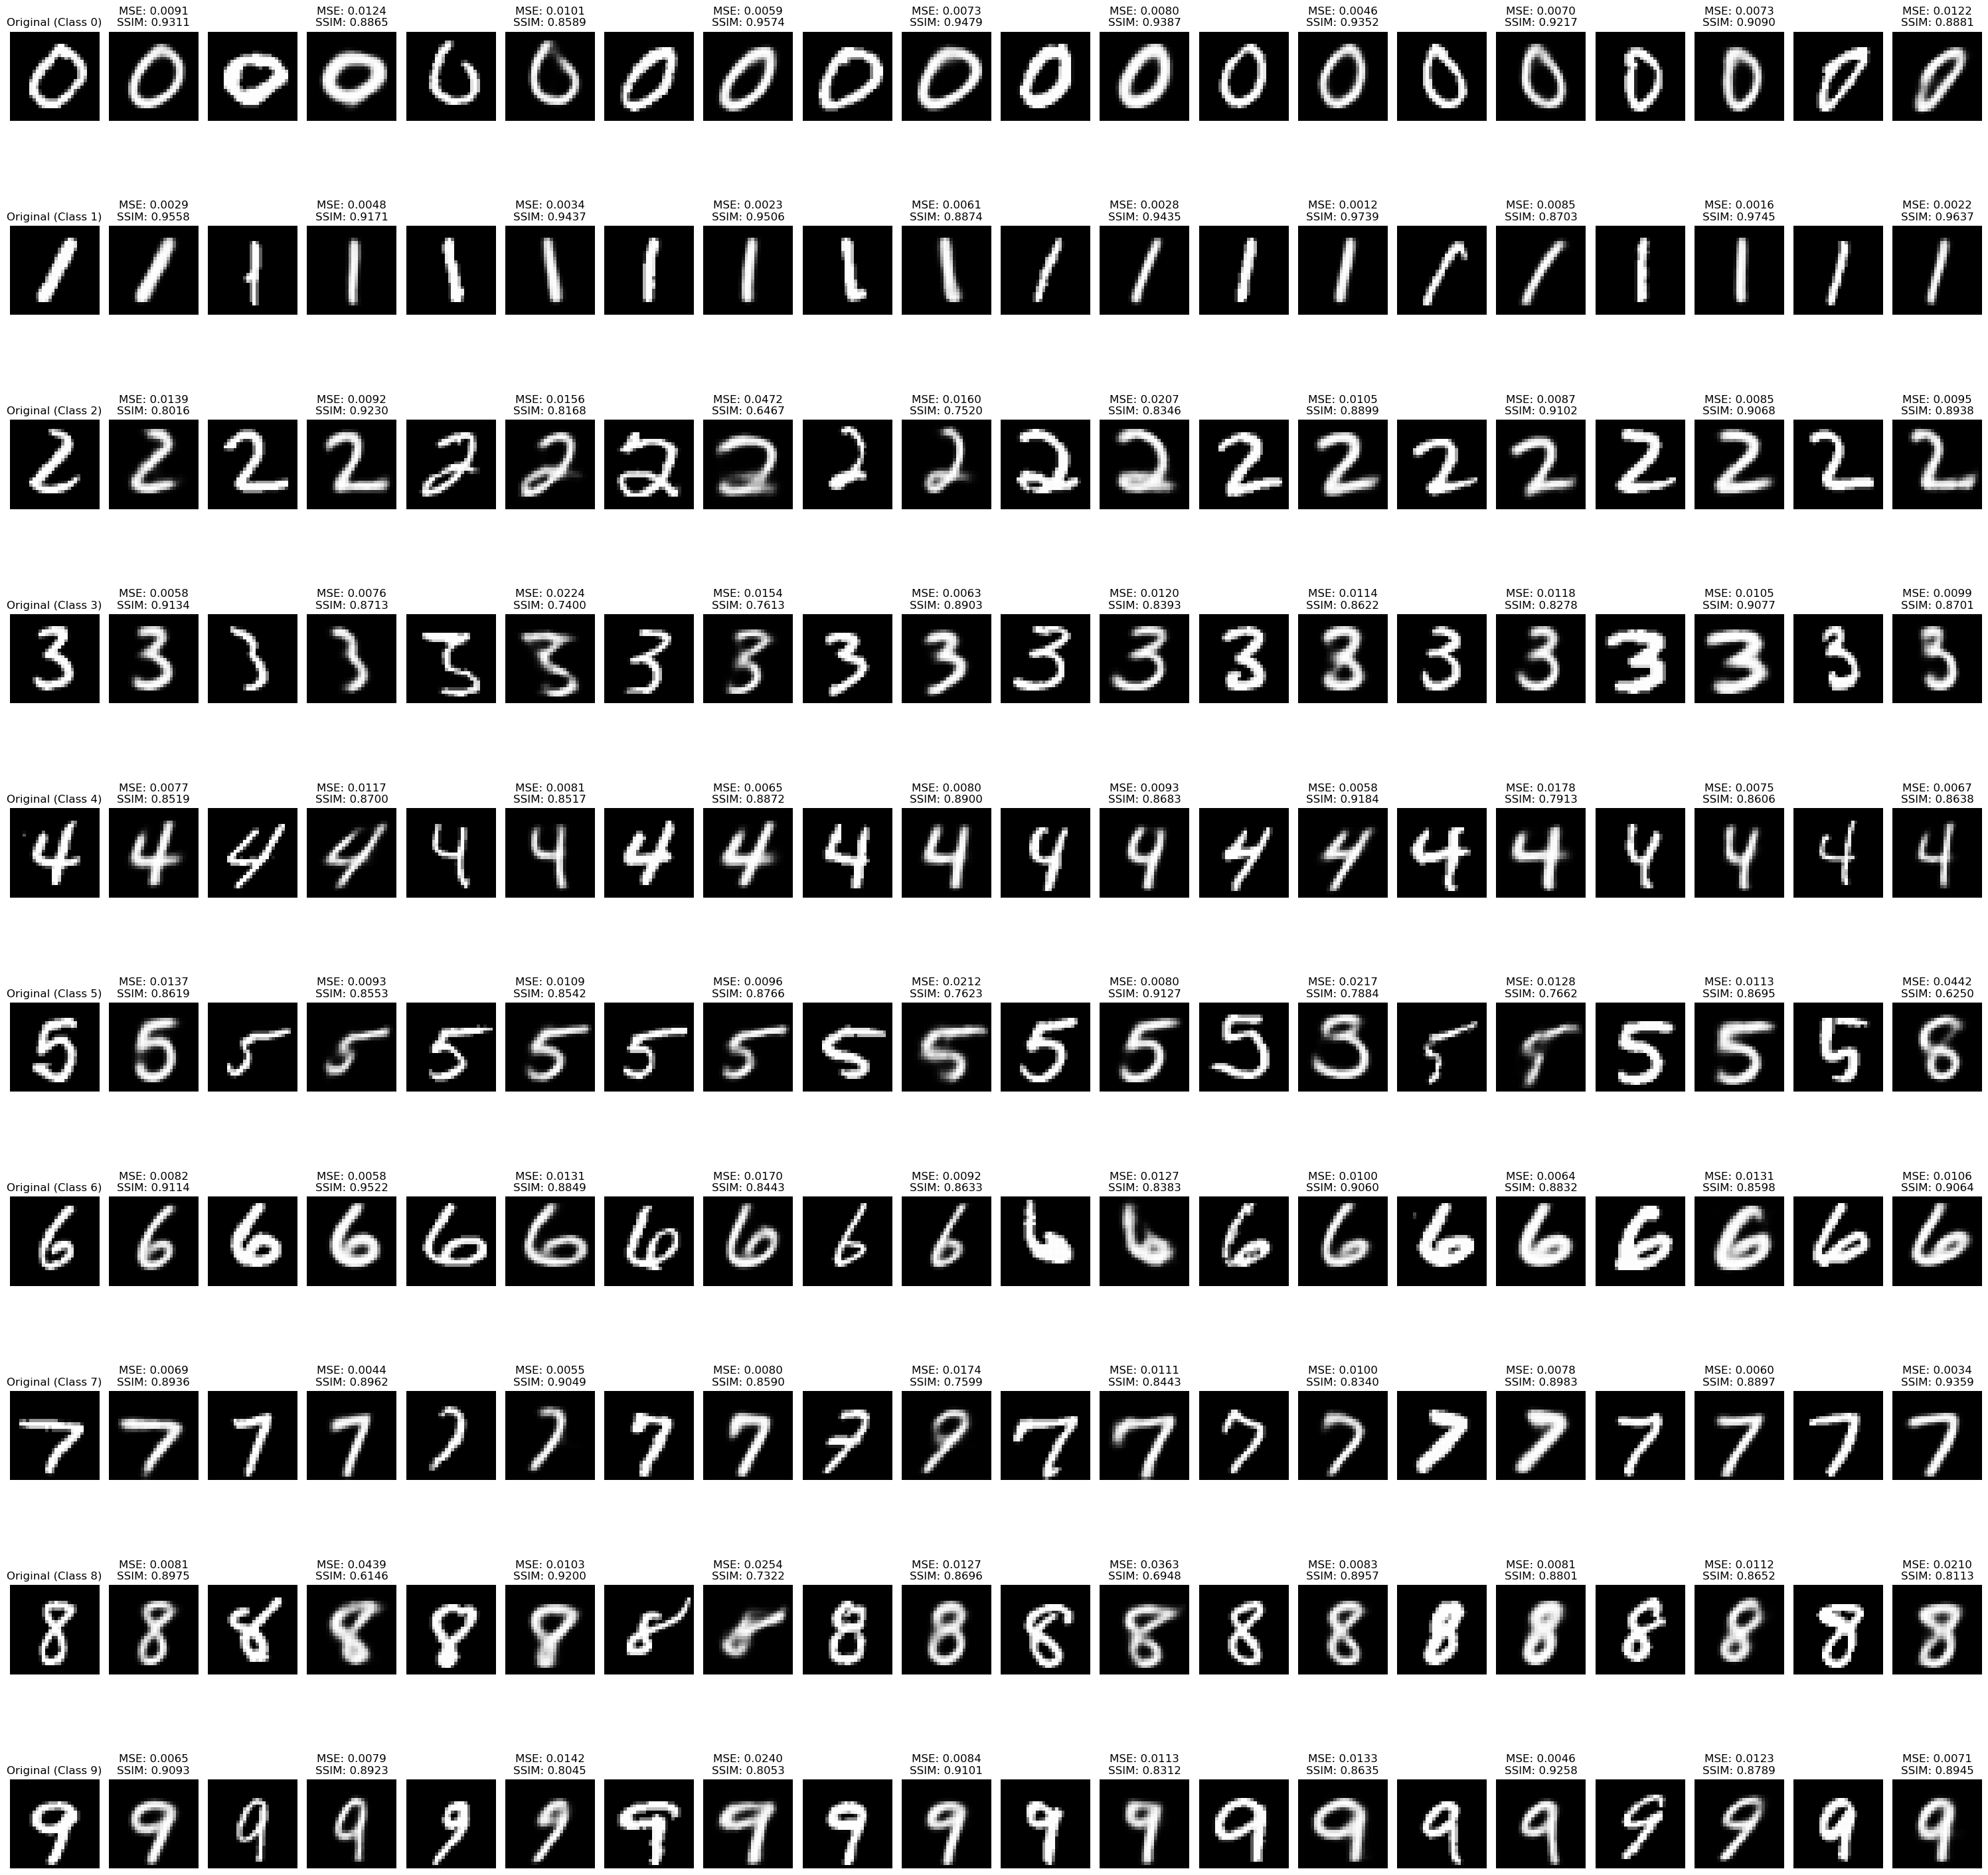

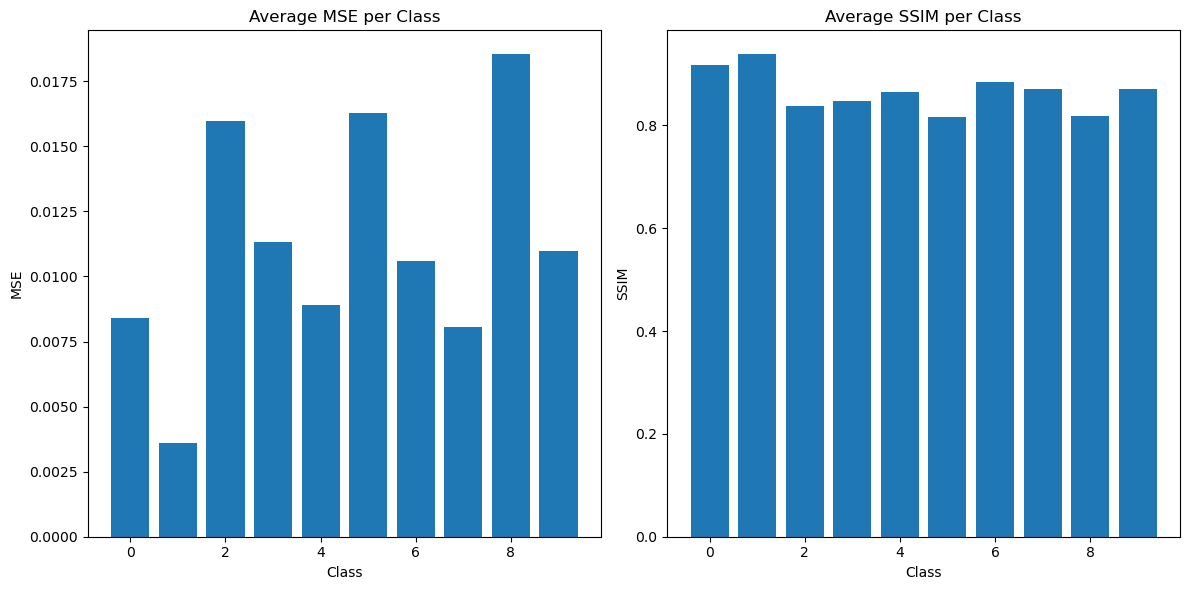

({0: 0.008386347,
  1: 0.0035827484,
  2: 0.015978832,
  3: 0.011306507,
  4: 0.008918352,
  5: 0.016267773,
  6: 0.010593386,
  7: 0.008053409,
  8: 0.0185307,
  9: 0.01095992},
 {0: 0.9174537232439592,
  1: 0.9380484997371331,
  2: 0.8375430663025598,
  3: 0.8483353782008635,
  4: 0.8653204956357483,
  5: 0.8172085159980105,
  6: 0.8849799291690147,
  7: 0.8715847668005153,
  8: 0.8180865825949446,
  9: 0.8715380118926566})

In [27]:
# def analyze_per_class_reconstruction(encoder, decoder, data, labels, n_samples_per_class=10):

encoder, decoder, data, labels, n_samples_per_class = variational_encoder, variational_decoder, x_test, y_test, 10

"""Analyze reconstruction quality per class"""
# Get unique labels
unique_labels = np.unique(labels)

# Create a figure
fig, axes = plt.subplots(len(unique_labels), n_samples_per_class * 2, 
                        figsize=(n_samples_per_class * 3, len(unique_labels) * 3))

# Track metrics per class
mse_per_class = {label: [] for label in unique_labels}
ssim_per_class = {label: [] for label in unique_labels}

# For each class
for i, label in enumerate(unique_labels):
    # Get indices for this class
    indices = np.where(labels == label)[0]
    
    # Sample a few examples
    if len(indices) > n_samples_per_class:
        sample_indices = np.random.choice(indices, n_samples_per_class, replace=False)
    else:
        sample_indices = indices
    
    # For each sample
    for j, idx in enumerate(sample_indices):
        # Get the original image
        original = data[idx]
        
        # Reconstruct the image
        z_mean, z_log_var, z = encoder.predict(np.expand_dims(original, axis=0), verbose=0)
        reconstructed = decoder.predict(z_mean, verbose=0)[0]
        
        # Calculate metrics
        mse = np.mean((original - reconstructed) ** 2)
        mse_per_class[label].append(mse)
        
        orig_img = original.reshape(28, 28)
        recon_img = reconstructed.reshape(28, 28)
        ssim_val = structural_similarity(orig_img, recon_img, data_range=1.)
        ssim_per_class[label].append(ssim_val)
        
        # Plot original and reconstruction
        axes[i, j*2].imshow(original.reshape(28, 28), cmap='gray')
        axes[i, j*2].axis('off')
        if j == 0:
            axes[i, j*2].set_title(f'Original (Class {label})')
        
        axes[i, j*2+1].imshow(reconstructed.reshape(28, 28), cmap='gray')
        axes[i, j*2+1].set_title(f'MSE: {mse:.4f}\nSSIM: {ssim_val:.4f}')
        axes[i, j*2+1].axis('off')

plt.tight_layout()
# plt.savefig(f"{create_diagnostics_folder()}/per_class_reconstruction.png")
plt.show()
plt.close()

# Compute average metrics per class
avg_mse_per_class = {label: np.mean(values) for label, values in mse_per_class.items()}
avg_ssim_per_class = {label: np.mean(values) for label, values in ssim_per_class.items()}

# Plot metrics per class
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.bar(avg_mse_per_class.keys(), avg_mse_per_class.values())
plt.title('Average MSE per Class')
plt.xlabel('Class')
plt.ylabel('MSE')

plt.subplot(1, 2, 2)
plt.bar(avg_ssim_per_class.keys(), avg_ssim_per_class.values())
plt.title('Average SSIM per Class')
plt.xlabel('Class')
plt.ylabel('SSIM')

plt.tight_layout()
# plt.savefig(f"{create_diagnostics_folder()}/metrics_per_class.png")
plt.show()
plt.close()

avg_mse_per_class, avg_ssim_per_class

#### Pixel-wise Error Maps

Visualize which parts of images have highest reconstruction error

2025-04-12 14:00:18.065498: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


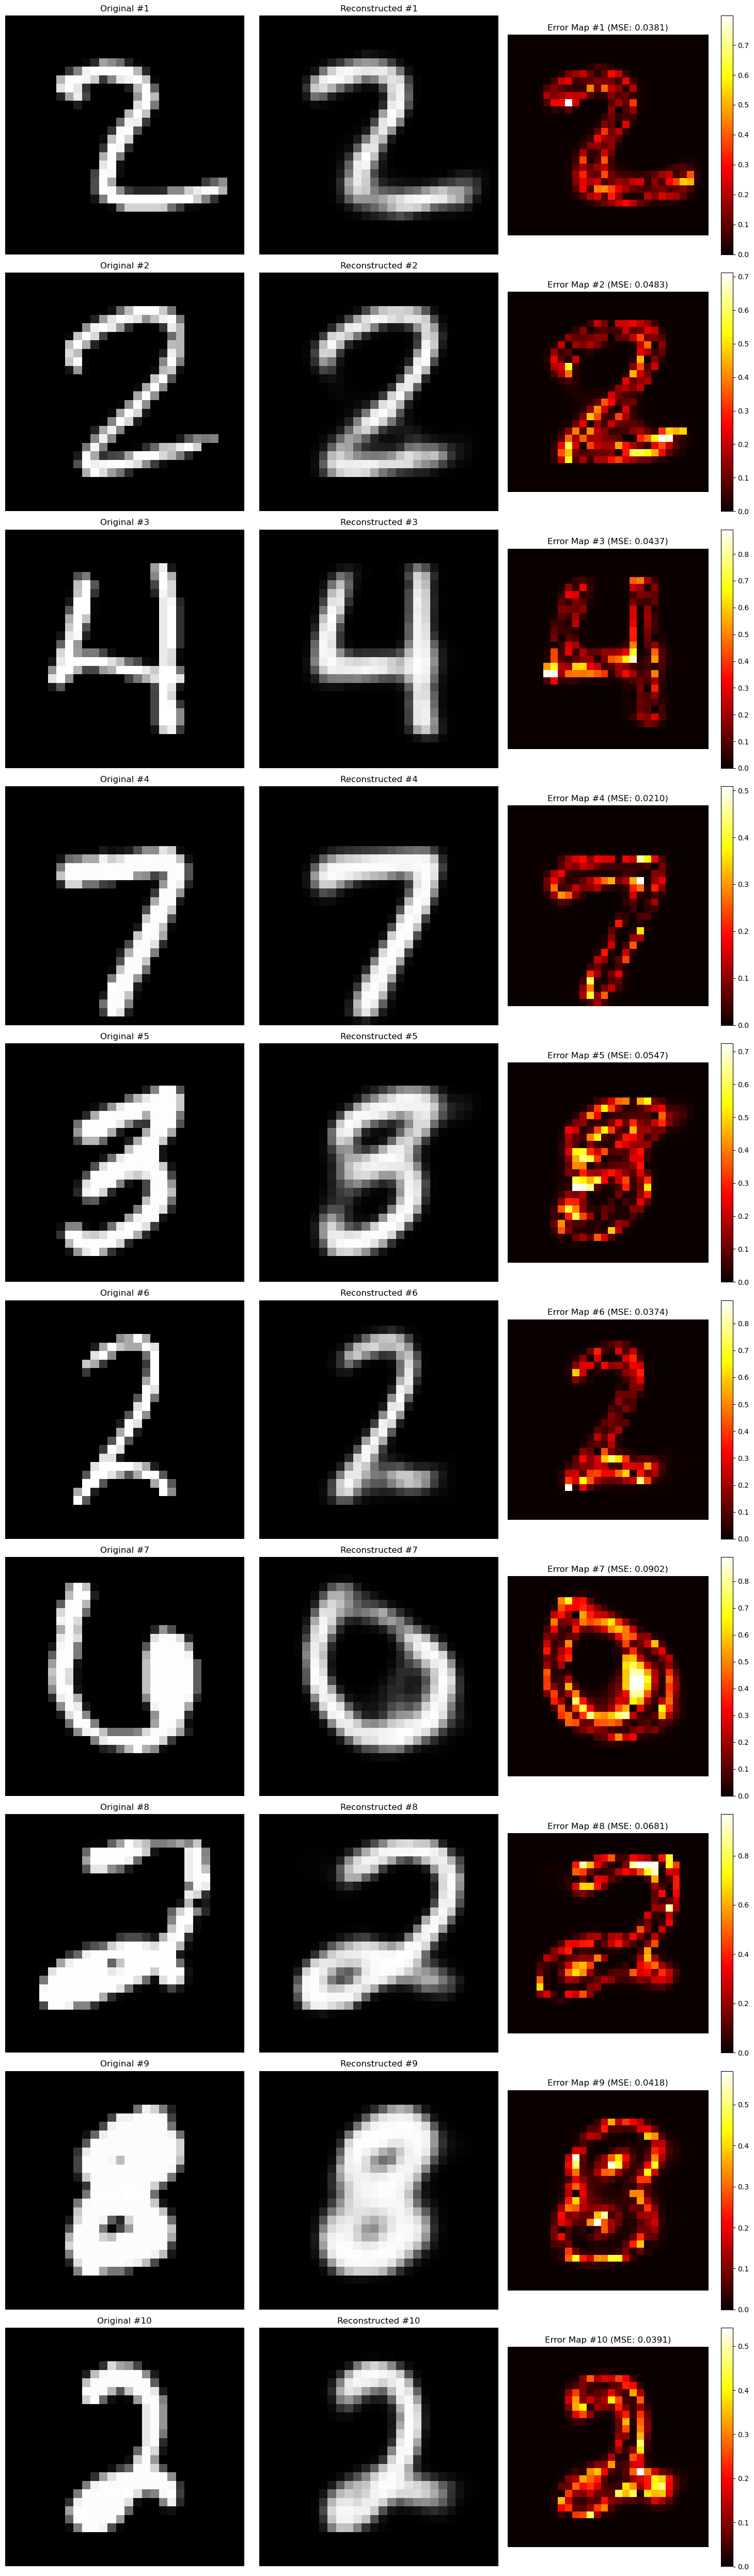

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


2025-04-12 14:00:22.030589: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


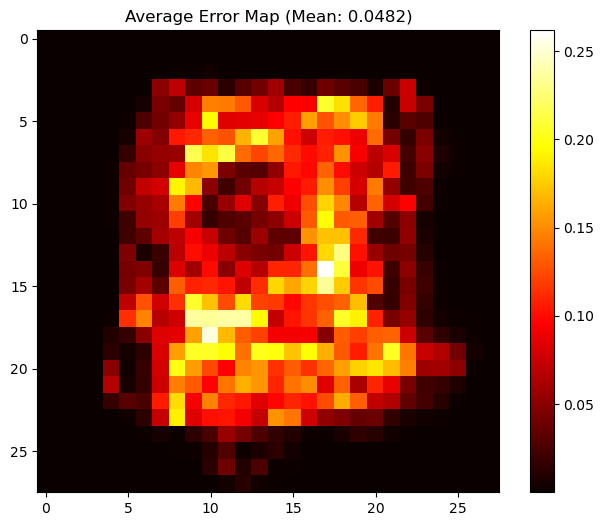

array([[4.93067892e-05, 2.12610030e-06, 1.40790959e-07, 2.07306783e-07,
        2.90181902e-07, 7.57882503e-07, 3.05894582e-06, 1.21892135e-05,
        9.05937395e-06, 1.34071070e-05, 2.12141840e-05, 2.52116879e-05,
        1.03823295e-05, 6.26193150e-06, 2.61635432e-06, 3.29138447e-06,
        5.32158629e-06, 7.17369039e-06, 4.61929721e-06, 2.89549325e-06,
        1.29113300e-06, 6.80589778e-07, 1.70826368e-07, 6.52890378e-07,
        2.18573518e-06, 1.14214470e-06, 1.05212642e-07, 1.94311974e-06],
       [1.03296372e-06, 1.38932679e-08, 6.76302392e-09, 1.45739154e-08,
        1.09086486e-07, 3.41870106e-07, 2.85764258e-06, 8.07390006e-06,
        1.26385548e-05, 2.35646821e-05, 4.18583149e-05, 9.54113420e-06,
        2.84599582e-06, 1.20975506e-06, 6.33260754e-07, 8.52296409e-07,
        2.45273645e-06, 2.62920139e-06, 2.53558164e-06, 9.06974151e-07,
        6.98170652e-07, 1.95128877e-07, 6.97594871e-08, 3.24120577e-07,
        5.94828691e-07, 1.05727125e-07, 2.67181854e-09, 3.15741

In [28]:
def visualize_pixel_error_maps(encoder, decoder, data, n_samples=10):

    """Visualize where in the image reconstruction errors occur"""
    # Sample data points
    if len(data) > n_samples:
        idx = np.random.choice(len(data), n_samples, replace=False)
        data_sample = data[idx]
    else:
        data_sample = data

    plt.figure(figsize=(15, 5 * n_samples))

    for i, original in enumerate(data_sample):
        # Reconstruct the image
        z_mean, z_log_var, z = encoder.predict(np.expand_dims(original, axis=0), verbose=0)
        reconstructed = decoder.predict(z_mean, verbose=0)[0]
        
        # Calculate error map
        error_map = np.abs(original - reconstructed).reshape(28, 28)
        
        # Plot
        plt.subplot(n_samples, 3, i*3 + 1)
        plt.imshow(original.reshape(28, 28), cmap='gray')
        plt.title(f'Original #{i+1}')
        plt.axis('off')
        
        plt.subplot(n_samples, 3, i*3 + 2)
        plt.imshow(reconstructed.reshape(28, 28), cmap='gray')
        plt.title(f'Reconstructed #{i+1}')
        plt.axis('off')
        
        plt.subplot(n_samples, 3, i*3 + 3)
        plt.imshow(error_map, cmap='hot')
        plt.colorbar()
        plt.title(f'Error Map #{i+1} (MSE: {np.mean(error_map):.4f})')
        plt.axis('off')

    plt.tight_layout()
    # plt.savefig(f"{create_diagnostics_folder()}/pixel_error_maps.png")
    plt.show()
    plt.close()

    # Calculate average error map
    all_error_maps = []
    for original in data_sample:
        z_mean, z_log_var, z = encoder.predict(np.expand_dims(original, axis=0))
        reconstructed = decoder.predict(z_mean)[0]
        error_map = np.abs(original - reconstructed).reshape(28, 28)
        all_error_maps.append(error_map)

    avg_error_map = np.mean(all_error_maps, axis=0)

    plt.figure(figsize=(8, 6))
    plt.imshow(avg_error_map, cmap='hot')
    plt.colorbar()
    plt.title(f'Average Error Map (Mean: {np.mean(avg_error_map):.4f})')
    # plt.savefig(f"{create_diagnostics_folder()}/average_error_map.png")
    plt.show()
    plt.close()

    return avg_error_map

visualize_pixel_error_maps(variational_encoder, variational_decoder, x_test)

#### Histogram of Errors

Check if errors are normally distributed or skewed

In [29]:
def plot_error_distribution(encoder, decoder, data, n_samples=1000):

    """Plot histogram of pixel-wise reconstruction errors"""
    # Sample data points
    if len(data) > n_samples:
        idx = np.random.choice(len(data), n_samples, replace=False)
        data_sample = data[idx]
    else:
        data_sample = data

    all_errors = []

    # Calculate errors for all samples
    for original in data_sample:
        z_mean, z_log_var, z = encoder.predict(np.expand_dims(original, axis=0), verbose=0)
        reconstructed = decoder.predict(z_mean, verbose=0)[0]
        error = (original - reconstructed)
        all_errors.extend(error)

    all_errors = np.array(all_errors)

    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.hist(all_errors.flatten(), bins=50, alpha=0.7, color='blue')
    plt.title('Distribution of Reconstruction Errors')
    plt.xlabel('Error Value')
    plt.ylabel('Frequency')

    plt.subplot(1, 2, 2)
    stats.probplot(all_errors.flatten(), plot=plt)
    plt.title('Q-Q Plot of Errors')

    plt.tight_layout()
    # plt.savefig(f"{create_diagnostics_folder()}/error_distribution.png")
    plt.show()
    plt.close()

    # Check for normality with Shapiro-Wilk test
    # (sampling a subset because Shapiro-Wilk can't handle large samples)
    error_sample = np.random.choice(all_errors.flatten(), size=min(5000, len(all_errors)), replace=False)
    shapiro_test = stats.shapiro(error_sample)
    print(f"Shapiro-Wilk test for normality: W={shapiro_test[0]:.4f}, p-value={shapiro_test[1]:.4f}")
    
    return shapiro_test

# Doesn't change that much so not very useful
# plot_error_distribution(variational_encoder, variational_decoder, x_test)

### Image Generation

In [30]:
codings = tf.random.normal(shape=[3 * 7, LATENT_DIM])
images = variational_decoder(codings).numpy()

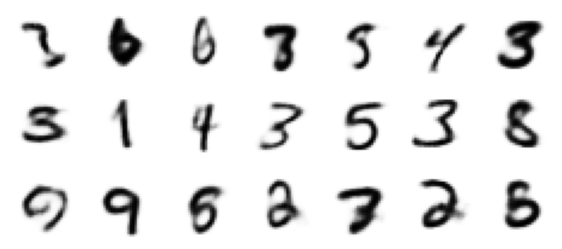

In [31]:
def plot_multiple_images(images, n_cols=None):
    n_cols = n_cols or len(images)
    n_rows = (len(images) - 1) // n_cols + 1
    if images.shape[-1] == 1:
        images = images.squeeze(axis=-1)
    plt.figure(figsize=(n_cols, n_rows))
    for index, image in enumerate(images):
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(image, cmap="binary")
        plt.axis("off")

plot_multiple_images(images, 7)
plt.savefig(os.path.join(current_logs_path, "image_generation.png"))
plt.show()

#### Evaluate based on Simple Classifier

In [32]:
# Evaluate classifier on REAL test data (as a baseline)
_, real_accuracy = classifier.evaluate(x_test, y_test, verbose=0)
print(f"Simple classifier accuracy on REAL test data: {real_accuracy:.4f}")

# Generate a large batch of images
n_generated_for_eval = 5000
random_latent_vectors_eval = np.random.normal(size=(n_generated_for_eval, LATENT_DIM))
generated_images_eval = variational_decoder.predict(random_latent_vectors_eval)

# Predict labels for generated images
generated_predictions = classifier.predict(generated_images_eval)
generated_labels = np.argmax(generated_predictions, axis=1)
generated_confidence = np.mean(np.max(generated_predictions, axis=1))

# Score: Average confidence of the classifier on generated images.
# Higher confidence suggests the classifier "recognizes" the generated images better.
print(f"Average classifier confidence on {n_generated_for_eval} GENERATED images: {generated_confidence:.4f}")

# Mean classifier confidence
logs["MCC"] = generated_confidence

Simple classifier accuracy on REAL test data: 0.9224
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Average classifier confidence on 5000 GENERATED images: 0.7502


#### Distribution of predicted labels for generated images

A good generator should produce all digits somewhat evenly.

In [33]:
print("Distribution of predicted labels for generated images:")
generated_labels_distr = dict(zip(np.histogram(generated_labels, bins=np.arange(11))[1], np.histogram(generated_labels, bins=np.arange(11))[0]))
print(generated_labels_distr)

Distribution of predicted labels for generated images:
{0: 341, 1: 450, 2: 502, 3: 737, 4: 497, 5: 248, 6: 579, 7: 448, 8: 586, 9: 612}


In [34]:
norm_generated_labels_distr = {k: v / n_generated_for_eval for k, v in generated_labels_distr.items()}

gini = gini_coefficient(list(norm_generated_labels_distr.values()))
print(f"Gini coefficient for class distribution of generated images: {gini}")
logs["GINI"] = gini

Gini coefficient for class distribution of generated images: 0.14760000000000004


### Latent space exploration

#### Plot latent space (dimensionality reduced to 2)

Visualize how your latent space is organized and if similar digits cluster together

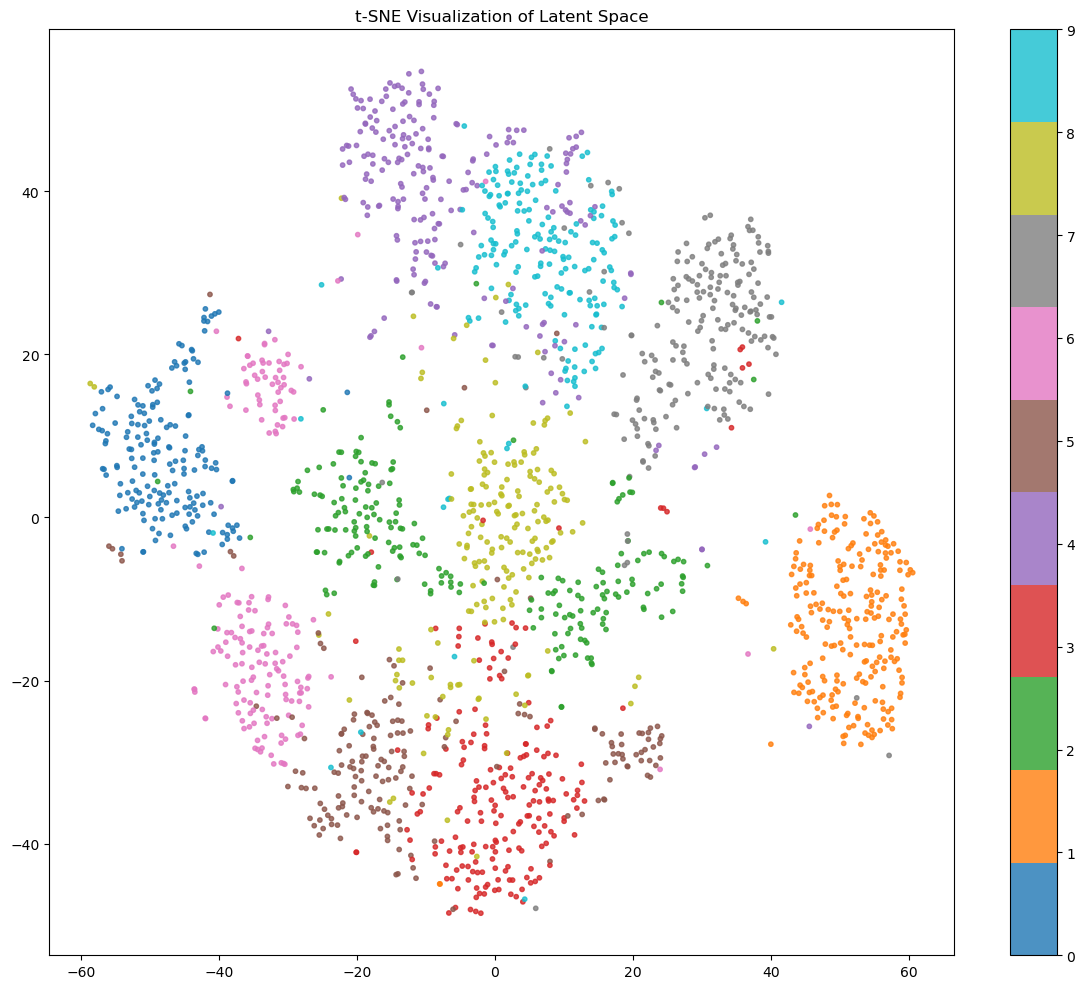

In [35]:
n_samples = 2000

samples = x_test[:n_samples]
labels = y_test[:n_samples]

# Encode to latent space
codings_mean, codings_log_var, codings = variational_encoder(samples)

# Dimensionality reduction with t-SNE
tsne = TSNE(n_components=2, perplexity=30, learning_rate=200)
z_tsne = tsne.fit_transform(codings_mean)

# Plot
plt.figure(figsize=(12, 10))
scatter = plt.scatter(z_tsne[:, 0], z_tsne[:, 1], c=labels,
            cmap='tab10', s=10, alpha=0.8)
plt.colorbar(scatter, ticks=range(10))
plt.title("t-SNE Visualization of Latent Space")
plt.tight_layout()
plt.savefig(os.path.join(current_logs_path, "latent_space.png"))
plt.show()

#### Latent Traversals

Interpolate between points in latent space to see if transitions are smooth

2025-04-12 14:00:43.425400: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-04-12 14:00:48.679181: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

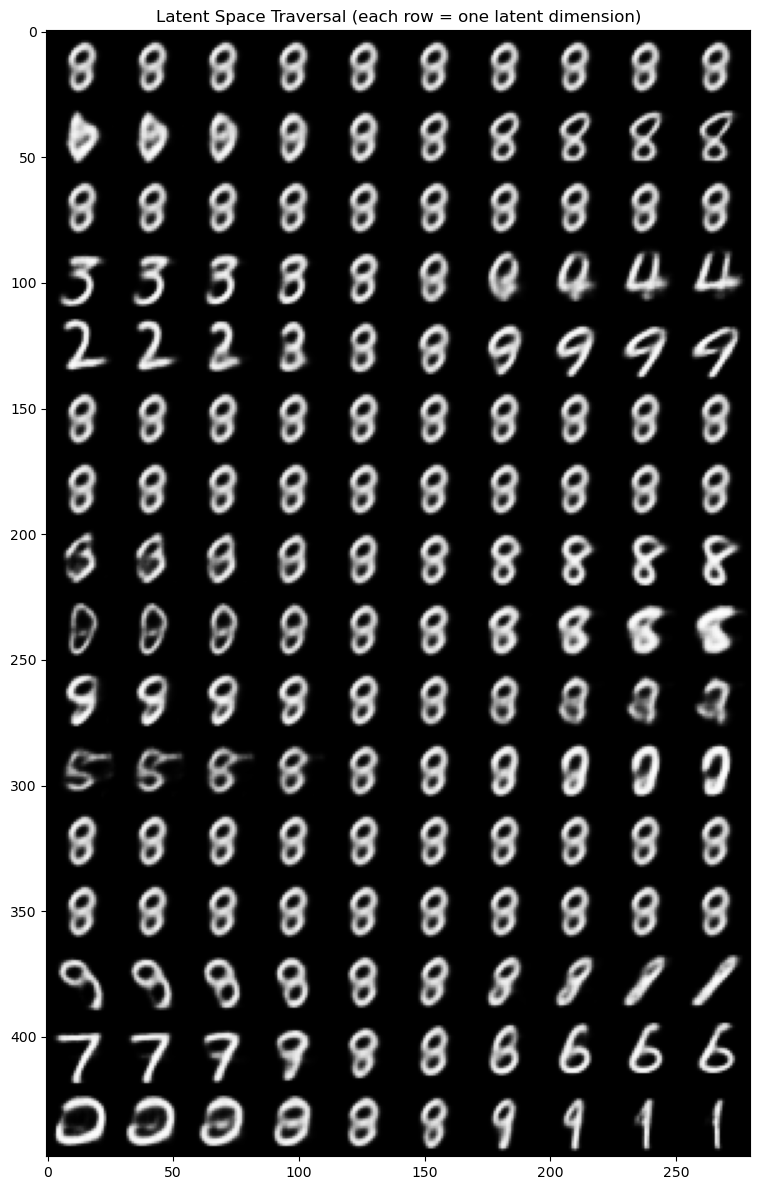

In [36]:
def plot_latent_traversal(decoder, latent_dim, start=-3, end=3, steps=10, digit_shape=(28, 28)):
    """
    Generate latent space traversals to visualize continuity and feature control
    """
    # Create a grid to hold the generated images
    figure = np.zeros((digit_shape[0] * latent_dim, digit_shape[1] * steps))
    
    # Values to traverse for each dimension
    values = np.linspace(start, end, steps)
    
    # For each latent dimension
    for i in range(latent_dim):
        # For each value along the traversal
        for j, v in enumerate(values):
            # Create a latent vector with zeros
            z_sample = np.zeros((1, latent_dim))
            # Set the current dimension to the current value
            z_sample[0, i] = v
            
            # Decode the latent vector
            x_decoded = decoder.predict(z_sample, verbose=0)
            digit = x_decoded[0].reshape(digit_shape)
            
            # Add the digit to the grid
            figure[i * digit_shape[0]:(i + 1) * digit_shape[0],
                   j * digit_shape[1]:(j + 1) * digit_shape[1]] = digit
    
    # Display the grid
    plt.figure(figsize=(12, 12))
    plt.imshow(figure, cmap='gray')
    plt.title('Latent Space Traversal (each row = one latent dimension)')
    plt.tight_layout()
    # plt.savefig(f"{create_diagnostics_folder()}/latent_traversal.png")
    plt.show()
    plt.close()

plot_latent_traversal(variational_decoder, LATENT_DIM)

#### Latent Grid

Generate a grid by varying two latent dimensions while keeping others fixed

2025-04-12 14:00:57.861892: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-04-12 14:01:03.105892: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

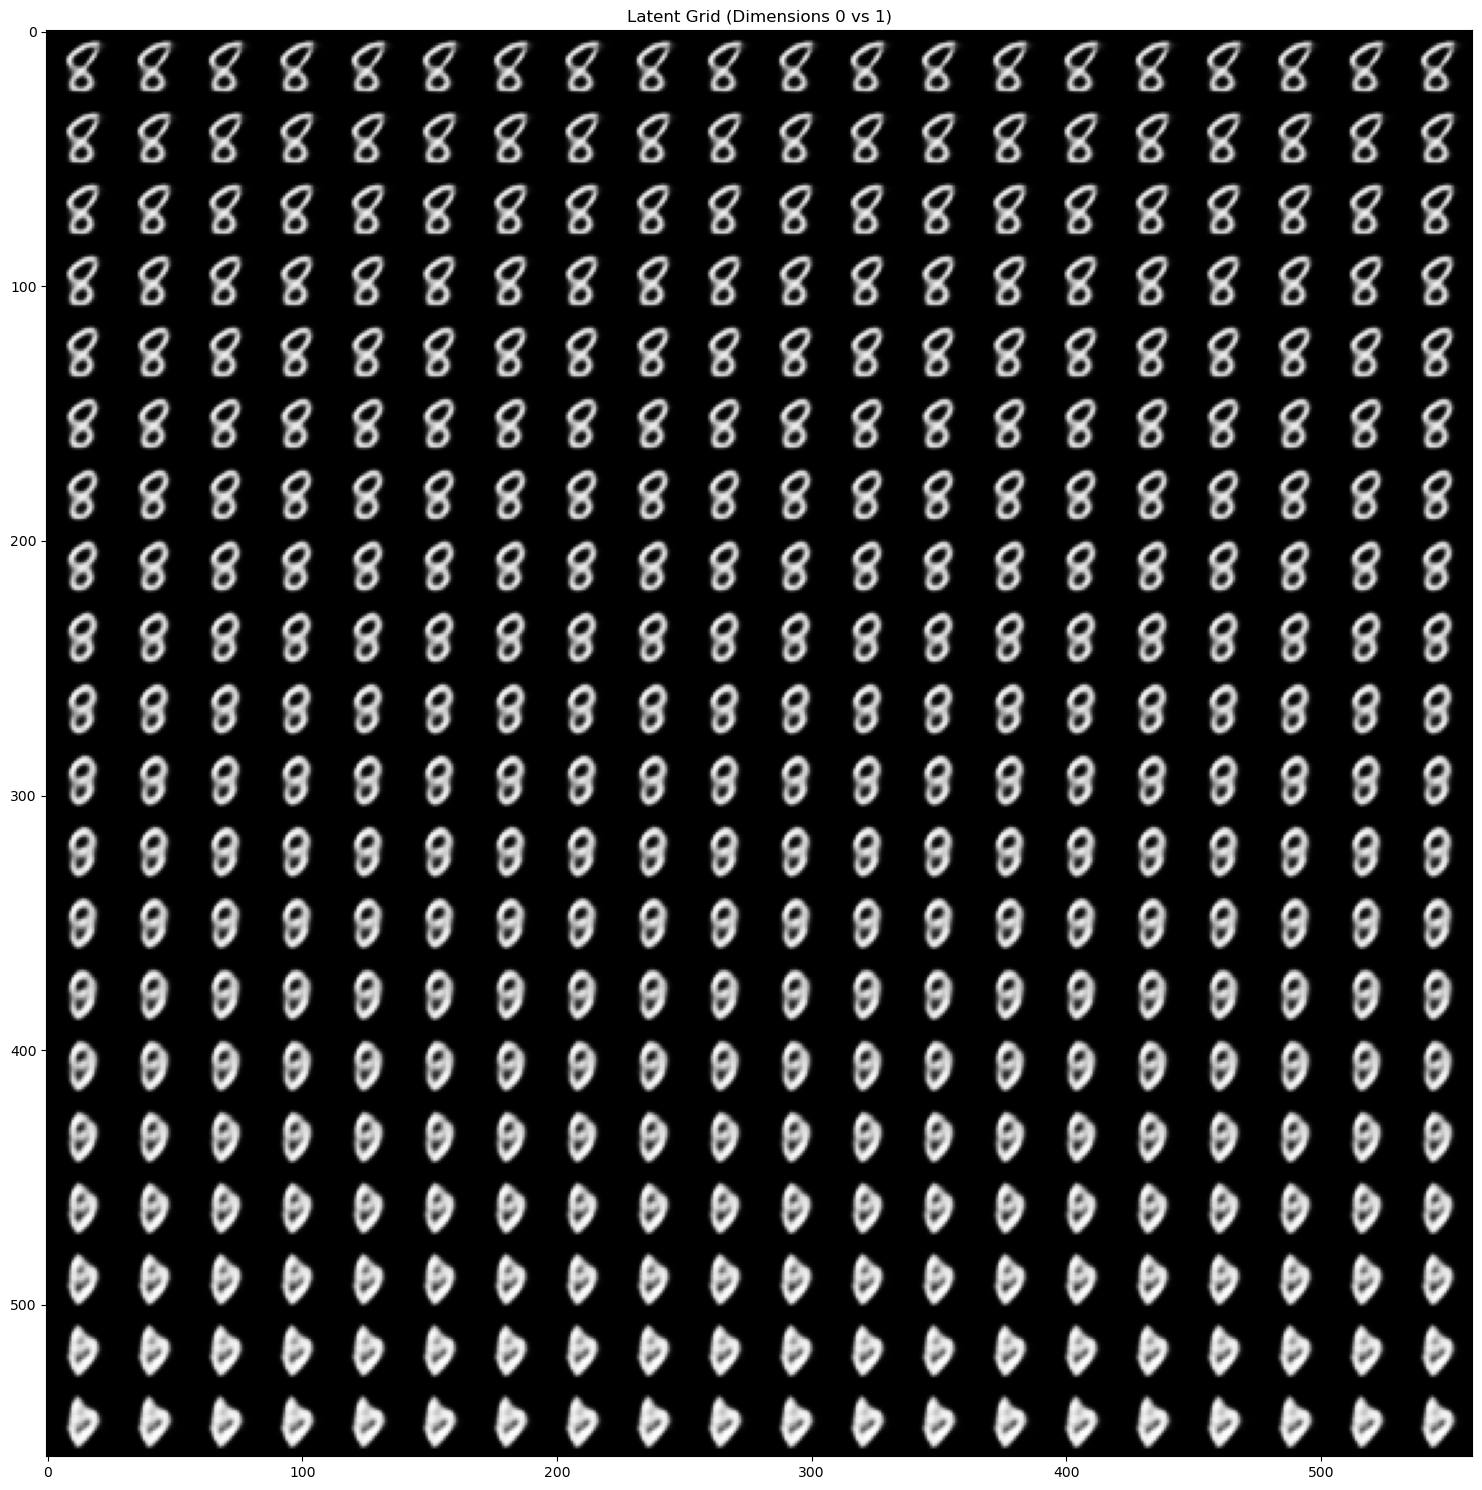

In [37]:
def plot_latent_grid(decoder, digit_shape=(28, 28), n=20, dimensions=(0, 1)):
    """
    Create a grid of images by varying two dimensions of the latent space
    """
    # Create a grid of latent values
    grid_x = np.linspace(-3, 3, n)
    grid_y = np.linspace(-3, 3, n)[::-1]
    
    figure = np.zeros((digit_shape[0] * n, digit_shape[1] * n))
    
    # Dimensions to vary
    dim1, dim2 = dimensions
    latent_dim = decoder.input_shape[1]
    
    # Generate images for each grid point
    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            # Create a latent vector with zeros
            z_sample = np.zeros((1, latent_dim))
            # Set the two dimensions we're varying
            z_sample[0, dim1] = xi
            z_sample[0, dim2] = yi
            
            # Decode the latent vector
            x_decoded = decoder.predict(z_sample, verbose=0)
            digit = x_decoded[0].reshape(digit_shape)
            
            # Add the digit to the grid
            figure[i * digit_shape[0]:(i + 1) * digit_shape[0],
                   j * digit_shape[1]:(j + 1) * digit_shape[1]] = digit
    
    # Display the grid
    plt.figure(figsize=(15, 15))
    plt.imshow(figure, cmap='gray')
    plt.title(f'Latent Grid (Dimensions {dim1} vs {dim2})')
    plt.tight_layout()
    # plt.savefig(f"{create_diagnostics_folder()}/latent_grid_dim{dim1}_{dim2}.png")
    plt.show()
    plt.close()

plot_latent_grid(variational_decoder)

#### PCA on Latent Space

Check if a few dimensions capture most variance or if it's evenly distributed

2025-04-12 14:01:23.582546: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


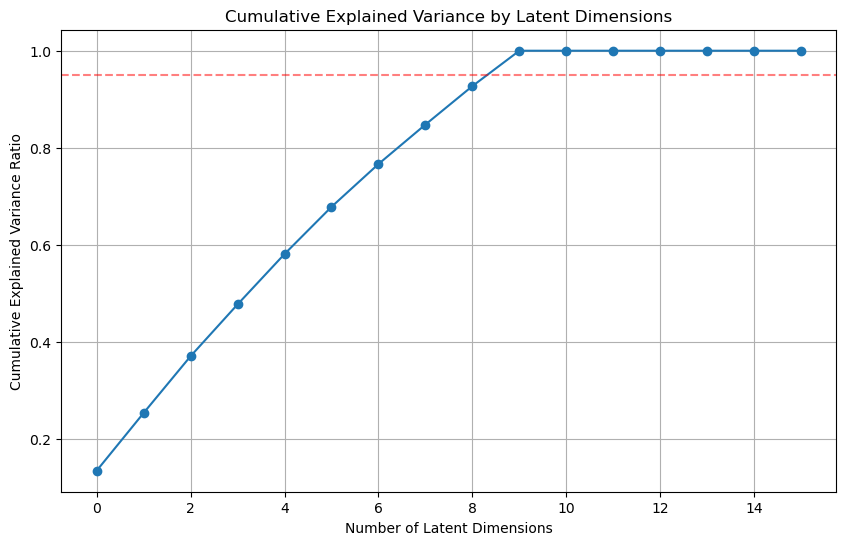

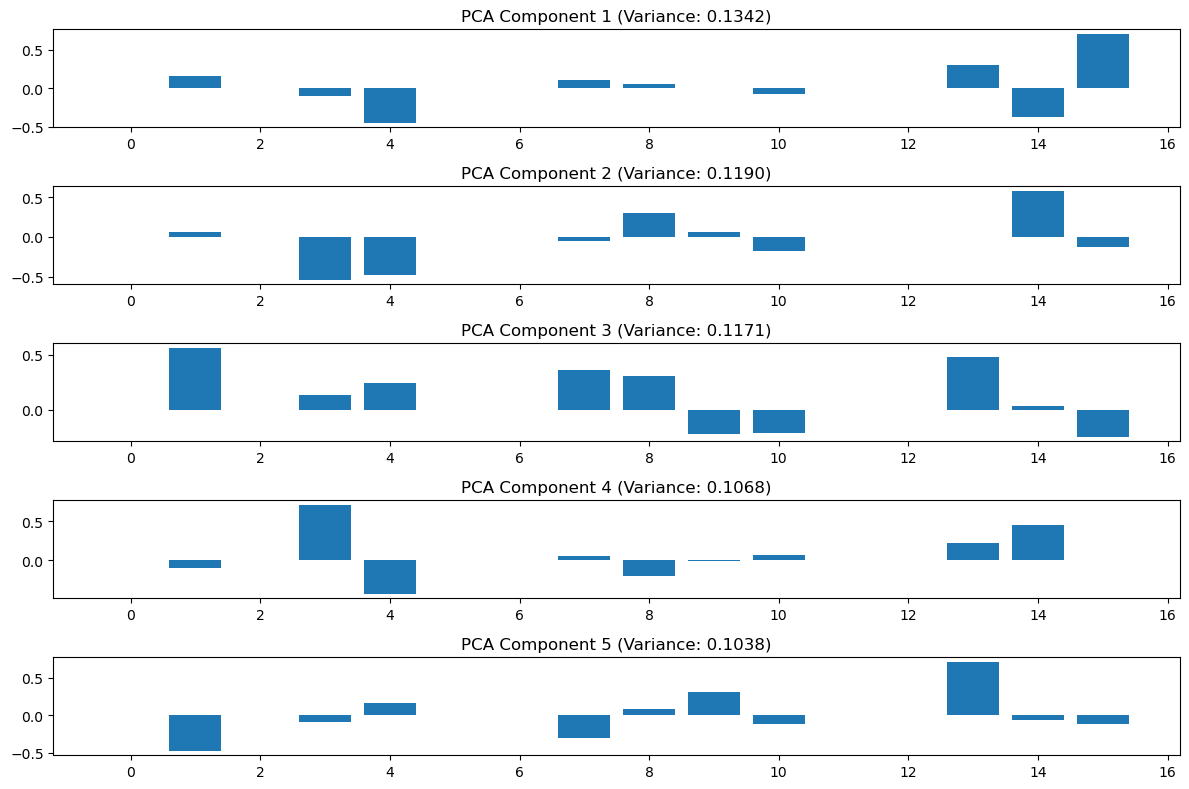

Number of dimensions needed for 95% variance: 10


(10,
 array([1.34170815e-01, 1.18982695e-01, 1.17074549e-01, 1.06773615e-01,
        1.03837572e-01, 9.72529799e-02, 8.82814601e-02, 8.13593492e-02,
        7.93023482e-02, 7.29563683e-02, 8.16916872e-06, 6.45900000e-13,
        1.03254672e-13, 2.24383873e-14, 0.00000000e+00, 0.00000000e+00],
       dtype=float32))

In [38]:
def analyze_latent_pca(encoder, data, n_samples=2000):
    """Analyze the latent space using PCA to check for dominant dimensions"""
    # Sample data points
    if len(data) > n_samples:
        idx = np.random.choice(len(data), n_samples, replace=False)
        data_sample = data[idx]
    else:
        data_sample = data
    
    # Encode data
    z_mean, z_log_var, z = encoder.predict(data_sample, verbose=0)
    
    # Apply PCA
    pca = PCA()
    pca.fit(z_mean)
    
    # Plot explained variance
    plt.figure(figsize=(10, 6))
    plt.plot(np.cumsum(pca.explained_variance_ratio_), '-o')
    plt.axhline(y=0.95, color='r', linestyle='--', alpha=0.5)
    plt.grid(True)
    plt.title('Cumulative Explained Variance by Latent Dimensions')
    plt.xlabel('Number of Latent Dimensions')
    plt.ylabel('Cumulative Explained Variance Ratio')
    # plt.savefig(f"{create_diagnostics_folder()}/latent_pca_variance.png")
    plt.show()
    plt.close()
    
    # Plot top principal components
    n_components = min(5, z_mean.shape[1])
    plt.figure(figsize=(12, 8))
    for i in range(n_components):
        plt.subplot(n_components, 1, i+1)
        plt.bar(range(z_mean.shape[1]), pca.components_[i])
        plt.title(f'PCA Component {i+1} (Variance: {pca.explained_variance_ratio_[i]:.4f})')
    plt.tight_layout()
    # plt.savefig(f"{create_diagnostics_folder()}/latent_pca_components.png")
    plt.show()
    plt.close()
    
    # Return the number of dimensions needed to explain 95% variance
    n_dims_95 = np.argmax(np.cumsum(pca.explained_variance_ratio_) >= 0.95) + 1
    print(f"Number of dimensions needed for 95% variance: {n_dims_95}")
    return n_dims_95, pca.explained_variance_ratio_

analyze_latent_pca(variational_encoder, x_test)

#### Average Variances per Latent Dimension

In [39]:
variances = np.exp(codings_log_var.numpy())

average_variances = np.mean(variances, axis=0)

print("Average Variances per Latent Dimension:")
for i, avg_var in enumerate(average_variances):
    print(f"Dimension {i}: {avg_var:.4f}")

Average Variances per Latent Dimension:
Dimension 0: 0.9968
Dimension 1: 0.1067
Dimension 2: 0.9971
Dimension 3: 0.0552
Dimension 4: 0.0302
Dimension 5: 0.9971
Dimension 6: 0.9978
Dimension 7: 0.1342
Dimension 8: 0.1127
Dimension 9: 0.2036
Dimension 10: 0.1430
Dimension 11: 0.9948
Dimension 12: 0.9985
Dimension 13: 0.0129
Dimension 14: 0.0326
Dimension 15: 0.0164


In [40]:
threshold = 1e-3  # Adjust this threshold as needed
unused_dimensions = np.where(average_variances < threshold)[0]
print(f"\nPotentially Unused Dimensions (below threshold {threshold}): {unused_dimensions}")


Potentially Unused Dimensions (below threshold 0.001): []


#### Adjusted Rand Index

In [41]:
# Perform clustering on the latent space
n_clusters = len(np.unique(y_test))  # Assuming the number of clusters equals the number of classes
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(codings_mean)

# Compute the ARI
ari_score = adjusted_rand_score(labels, cluster_labels)
print(f"Adjusted Rand Index (ARI): {ari_score}")

logs["ARI"] = ari_score

Adjusted Rand Index (ARI): 0.5270473174171896


#### Analyze KL Divergence Components

Break down KL divergence by dimension to see if certain dimensions contribute disproportionately

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


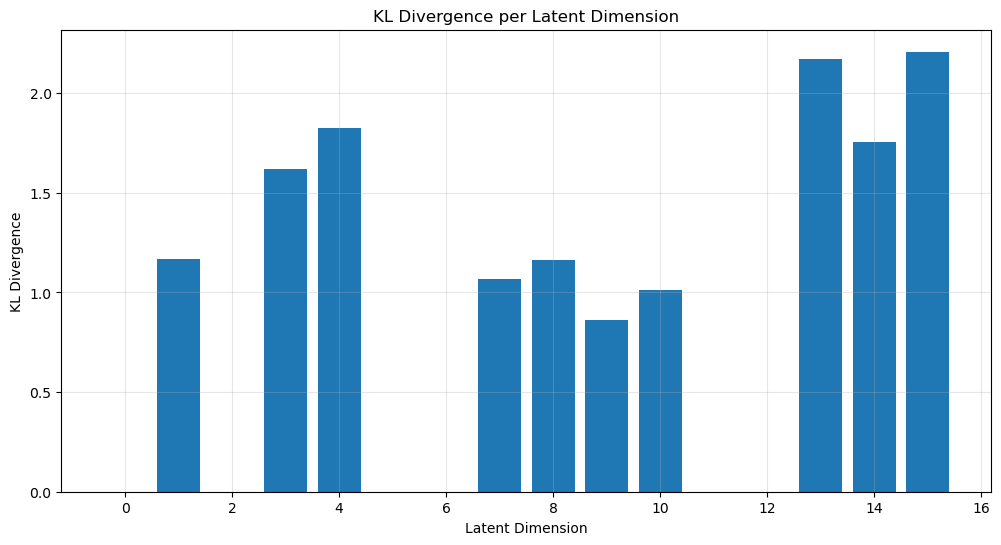

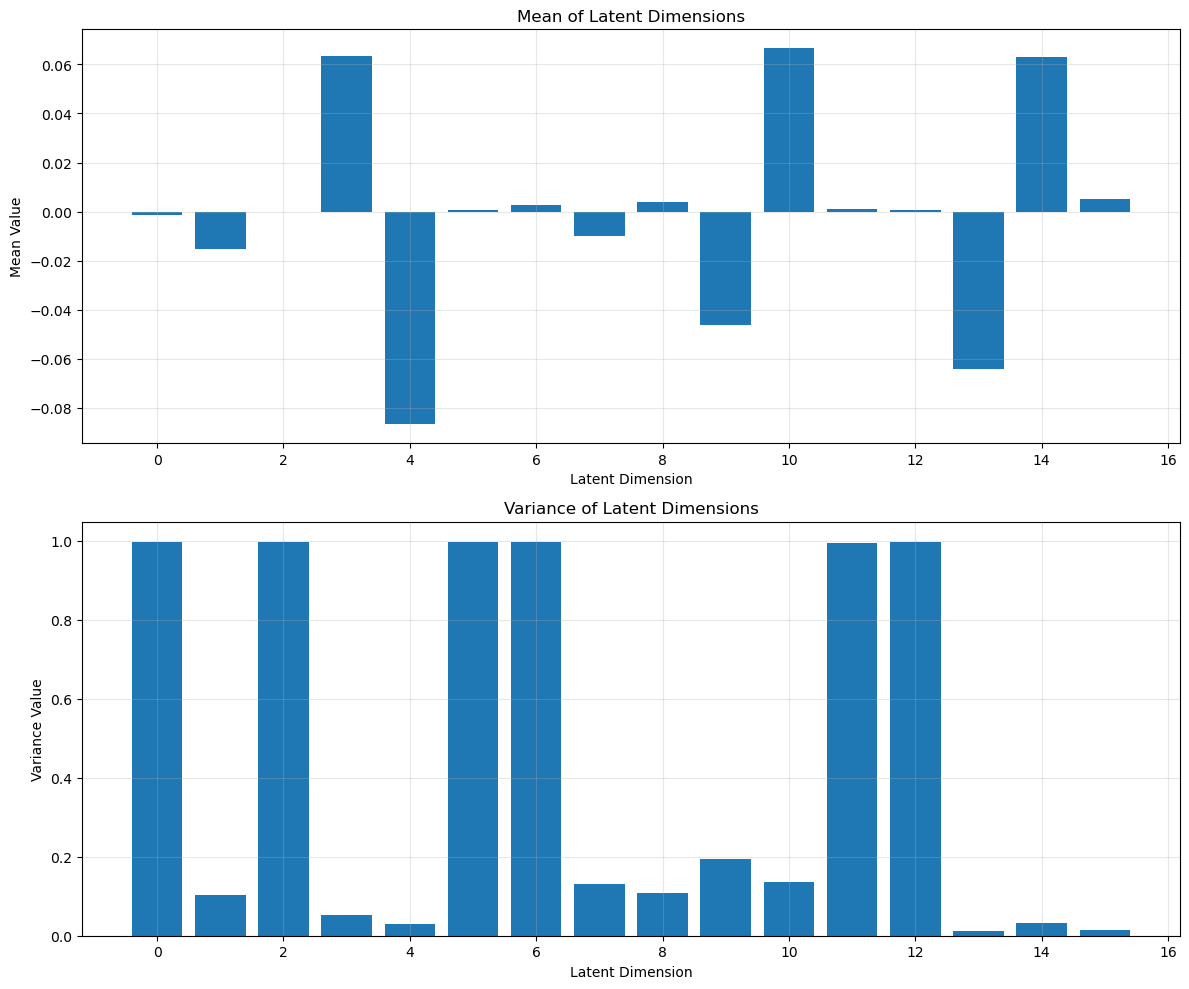

array([8.7741610e-06, 1.1686846e+00, 7.1800055e-06, 1.6215324e+00,
       1.8247151e+00, 3.5013913e-05, 6.8475010e-06, 1.0698465e+00,
       1.1632692e+00, 8.6280519e-01, 1.0106823e+00, 1.6769796e-05,
       2.6431383e-06, 2.1736698e+00, 1.7528449e+00, 2.2083907e+00],
      dtype=float32)

In [42]:
def analyze_kl_divergence_components(encoder, data, n_samples=1000):
    """Analyze which dimensions contribute most to KL divergence"""
    # Sample data points
    if len(data) > n_samples:
        idx = np.random.choice(len(data), n_samples, replace=False)
        data_sample = data[idx]
    else:
        data_sample = data
    
    # Encode data
    z_mean, z_log_var, z = encoder.predict(data_sample)
    
    # Calculate KL divergence for each dimension
    kl_per_dim = -0.5 * np.mean(1 + z_log_var - np.square(z_mean) - np.exp(z_log_var), axis=0)
    
    # Plot KL divergence per dimension
    plt.figure(figsize=(12, 6))
    plt.bar(range(len(kl_per_dim)), kl_per_dim)
    plt.title('KL Divergence per Latent Dimension')
    plt.xlabel('Latent Dimension')
    plt.ylabel('KL Divergence')
    plt.grid(True, alpha=0.3)
    # plt.savefig(f"{create_diagnostics_folder()}/kl_per_dimension.png")
    plt.show()
    plt.close()
    
    # Plot the mean and variance of the approximate posterior
    plt.figure(figsize=(12, 10))
    
    plt.subplot(2, 1, 1)
    plt.bar(range(z_mean.shape[1]), np.mean(z_mean, axis=0))
    plt.title('Mean of Latent Dimensions')
    plt.xlabel('Latent Dimension')
    plt.ylabel('Mean Value')
    plt.grid(True, alpha=0.3)
    
    plt.subplot(2, 1, 2)
    plt.bar(range(z_log_var.shape[1]), np.mean(np.exp(z_log_var), axis=0))
    plt.title('Variance of Latent Dimensions')
    plt.xlabel('Latent Dimension')
    plt.ylabel('Variance Value')
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    # plt.savefig(f"{create_diagnostics_folder()}/latent_stats.png")
    plt.show()
    plt.close()
    
    return kl_per_dim

analyze_kl_divergence_components(variational_encoder, x_test)

#### Check posterior collapse

Check if some latent dimensions are ignored (mean≈0, var≈1)

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


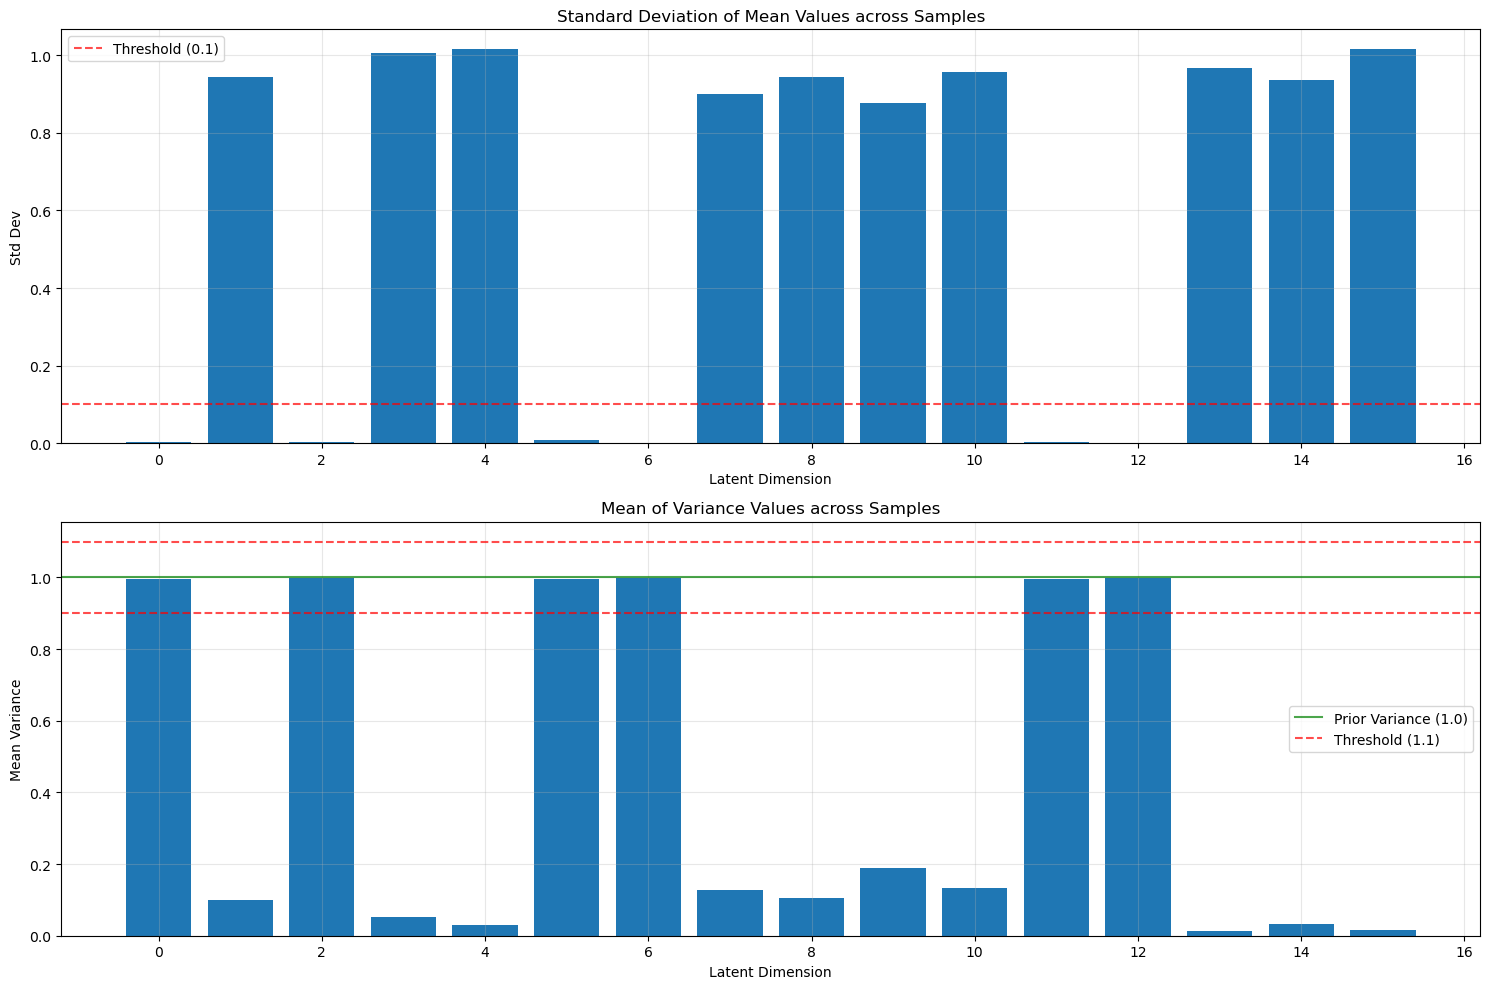

Potentially collapsed dimensions: [0, 2, 5, 6, 11, 12]
Number of potentially collapsed dimensions: 6


([0, 2, 5, 6, 11, 12],
 array([0.00268689, 0.94312066, 0.00279117, 1.006392  , 1.0150561 ,
        0.00774017, 0.00159937, 0.89965636, 0.94260293, 0.87773824,
        0.9565495 , 0.00381429, 0.00165945, 0.9674429 , 0.93630993,
        1.0158617 ], dtype=float32),
 array([0.9965789 , 0.1005137 , 0.9969575 , 0.05087325, 0.02869721,
        0.99683005, 0.9975575 , 0.1275201 , 0.10503726, 0.1884906 ,
        0.13410628, 0.9945155 , 0.9983301 , 0.01276086, 0.03167264,
        0.01539736], dtype=float32))

In [43]:
def check_posterior_collapse(encoder, data, n_samples=1000, threshold=0.1):
    """Check for posterior collapse (when latent dimensions are ignored)"""
    # Sample data points
    if len(data) > n_samples:
        idx = np.random.choice(len(data), n_samples, replace=False)
        data_sample = data[idx]
    else:
        data_sample = data
    
    # Encode data
    z_mean, z_log_var, z = encoder.predict(data_sample)
    
    # Calculate standard deviation of means across samples
    mean_std = np.std(z_mean, axis=0)
    
    # Calculate mean of variances across samples
    var_mean = np.mean(np.exp(z_log_var), axis=0)
    
    # Identify potentially collapsed dimensions
    collapsed_dims = []
    for i in range(len(mean_std)):
        if mean_std[i] < threshold and abs(var_mean[i] - 1.0) < threshold:
            collapsed_dims.append(i)
    
    # Plot diagnostics
    plt.figure(figsize=(15, 10))
    
    plt.subplot(2, 1, 1)
    plt.bar(range(len(mean_std)), mean_std)
    plt.axhline(y=threshold, color='r', linestyle='--', alpha=0.7, label=f'Threshold ({threshold})')
    plt.title('Standard Deviation of Mean Values across Samples')
    plt.xlabel('Latent Dimension')
    plt.ylabel('Std Dev')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.subplot(2, 1, 2)
    plt.bar(range(len(var_mean)), var_mean)
    plt.axhline(y=1.0, color='g', linestyle='-', alpha=0.7, label='Prior Variance (1.0)')
    plt.axhline(y=1.0+threshold, color='r', linestyle='--', alpha=0.7, label=f'Threshold ({1.0+threshold})')
    plt.axhline(y=1.0-threshold, color='r', linestyle='--', alpha=0.7)
    plt.title('Mean of Variance Values across Samples')
    plt.xlabel('Latent Dimension')
    plt.ylabel('Mean Variance')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    # plt.savefig(f"{create_diagnostics_folder()}/posterior_collapse.png")
    plt.show()
    plt.close()
    
    print(f"Potentially collapsed dimensions: {collapsed_dims}")
    print(f"Number of potentially collapsed dimensions: {len(collapsed_dims)}")
    
    return collapsed_dims, mean_std, var_mean

check_posterior_collapse(variational_encoder, x_test)

#### Plot Q-Q Plots

Compare your approximate posterior against the prior distribution

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


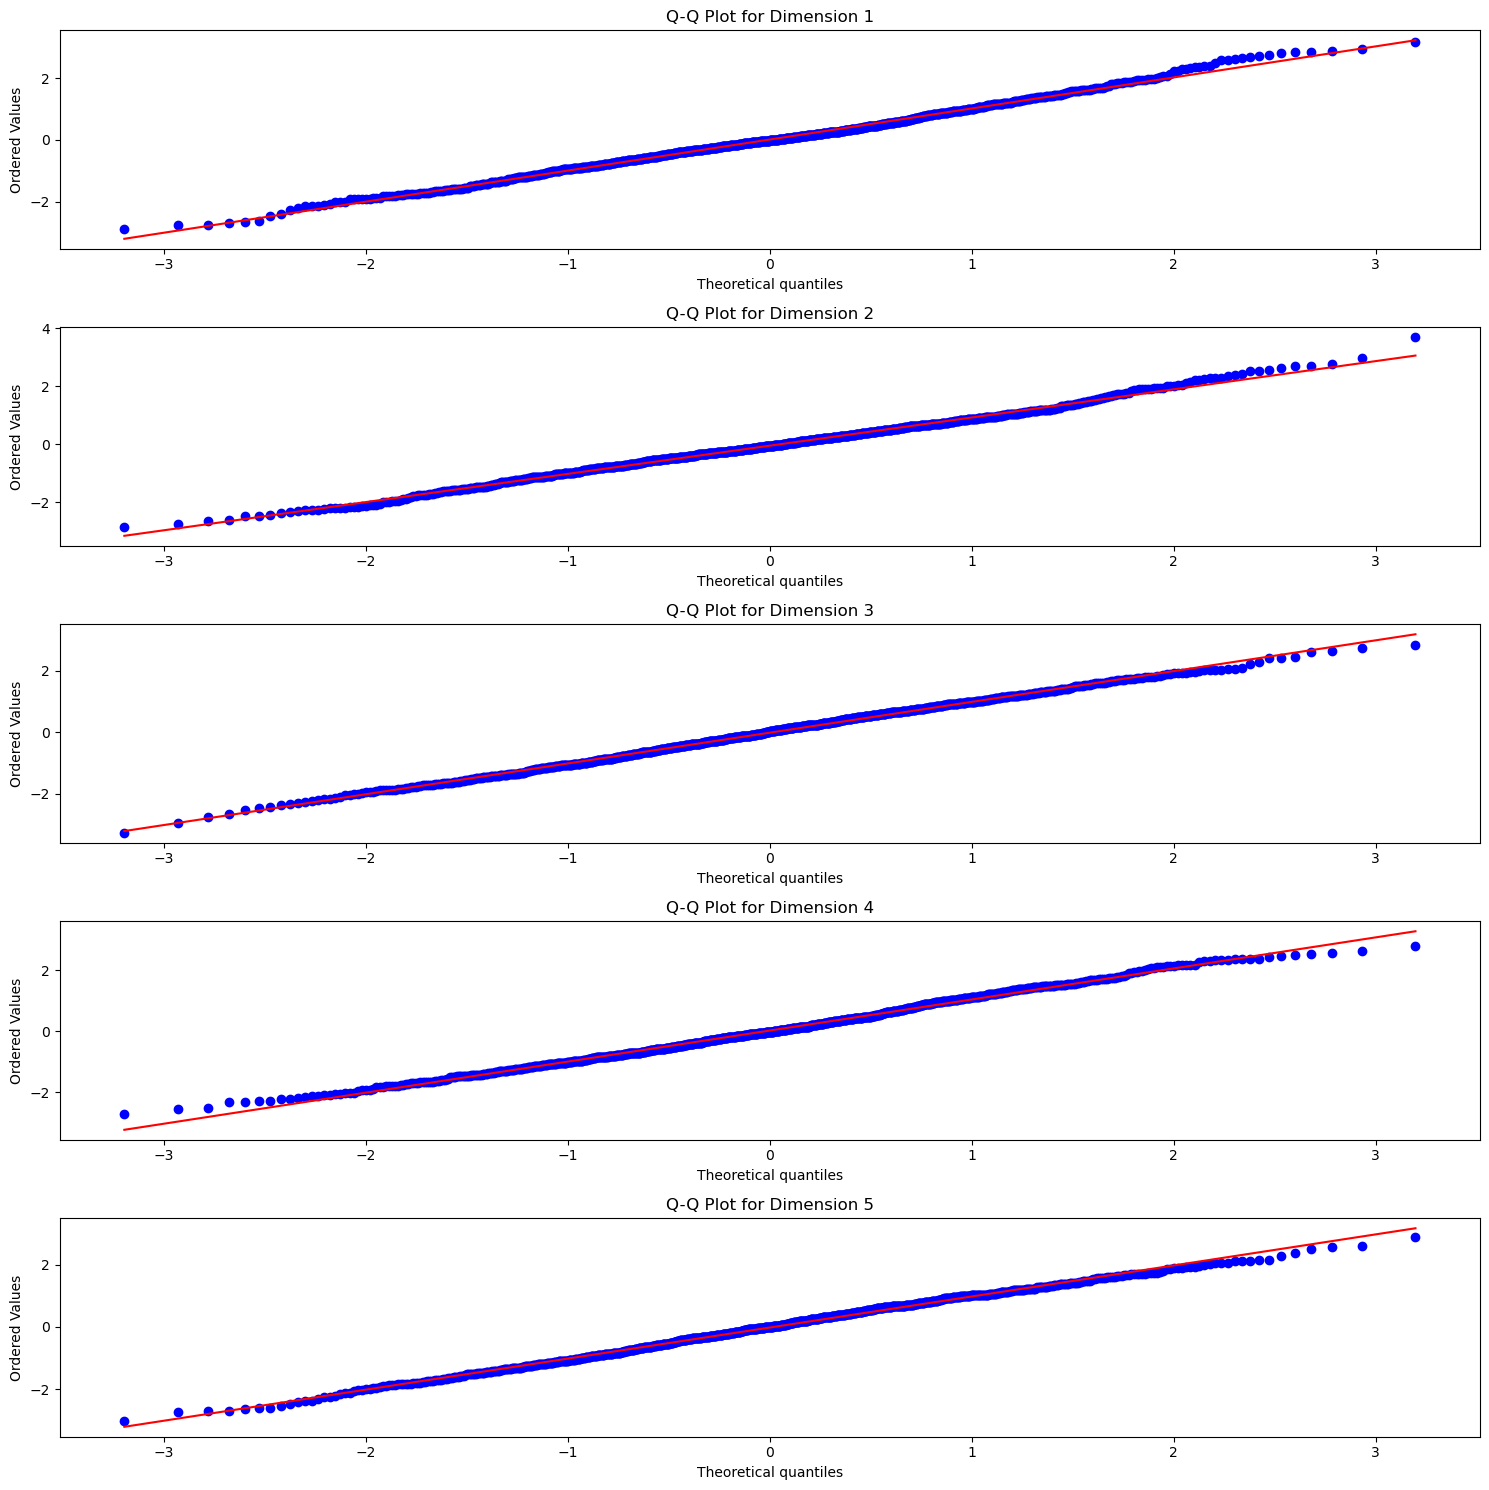

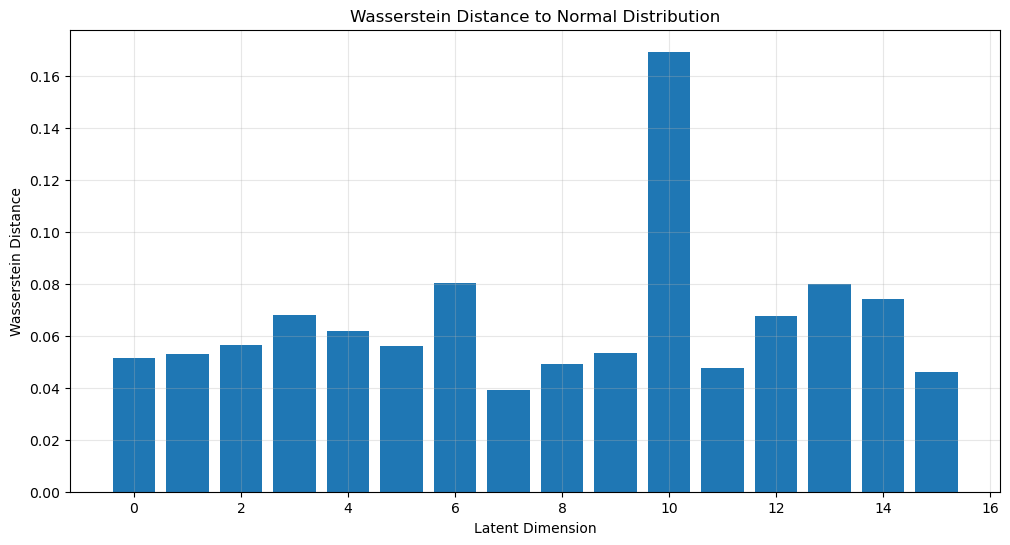

[0.051526645158928575,
 0.053071906347898906,
 0.05662151361728905,
 0.06799626159123275,
 0.061931164548837694,
 0.05617049934061885,
 0.08041724748971725,
 0.03930873892193157,
 0.04900452116978461,
 0.05333361978486147,
 0.1692914506626778,
 0.04767648557535046,
 0.06777595056044393,
 0.08003519478350579,
 0.0739904632497411,
 0.04621359025627964]

In [44]:
def plot_qq_distributions(encoder, data, n_samples=1000, n_dims=5):
    """Plot Q-Q plots comparing latent distributions to standard normal"""
    # Sample data points
    if len(data) > n_samples:
        idx = np.random.choice(len(data), n_samples, replace=False)
        data_sample = data[idx]
    else:
        data_sample = data
    
    # Encode data
    z_mean, z_log_var, z = encoder.predict(data_sample)
    
    # Prepare figure
    fig = plt.figure(figsize=(15, 3 * min(n_dims, z.shape[1])))
    
    # Plot Q-Q plots for first n_dims dimensions
    for i in range(min(n_dims, z.shape[1])):
        plt.subplot(min(n_dims, z.shape[1]), 1, i+1)
        stats.probplot(z[:, i], dist="norm", plot=plt)
        plt.title(f'Q-Q Plot for Dimension {i+1}')
    
    plt.tight_layout()
    # plt.savefig(f"{create_diagnostics_folder()}/qq_plots.png")
    plt.show()
    plt.close()
    
    # Calculate Wasserstein distance between each dimension and standard normal
    w_distances = []
    normal_samples = np.random.normal(0, 1, len(z))
    
    for i in range(z.shape[1]):
        w_dist = stats.wasserstein_distance(z[:, i], normal_samples)
        w_distances.append(w_dist)
    
    # Plot Wasserstein distances
    plt.figure(figsize=(12, 6))
    plt.bar(range(len(w_distances)), w_distances)
    plt.title('Wasserstein Distance to Normal Distribution')
    plt.xlabel('Latent Dimension')
    plt.ylabel('Wasserstein Distance')
    plt.grid(True, alpha=0.3)
    # plt.savefig(f"{create_diagnostics_folder()}/wasserstein_distances.png")
    plt.show()
    plt.close()
    
    return w_distances

plot_qq_distributions(variational_encoder, x_test)

### Semantic interpolation between 2 images

In [45]:
codings = np.zeros([7, LATENT_DIM])
codings[:, 0] = np.linspace(-0.8, 0.8, 7) 
images = variational_decoder(codings).numpy()

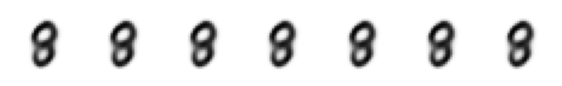

In [46]:
plot_multiple_images(images)
plt.savefig(os.path.join(current_logs_path, "sem_interpolation.png"))
plt.show()

## Save logs

In [47]:
logs

{'iteration': 99,
 'summary': 'Hyperparameter tuning before fitting',
 'EPOCHS': 100,
 'EARLY_STOPPING_PATIENCE': 10,
 'BATCH_SIZE': 128,
 'OPTIMIZER': 'adam',
 'LATENT_DIM': 16,
 'KL_WEIGHT': 2.0,
 'LEARNING_RATE': 0.0005,
 'LOSS': 117.12206268310547,
 'RECONSTRUCTION': 87.15011596679688,
 'KL': 14.936912536621094,
 'MSE': 0.016367033,
 'MTC': 0.8515406,
 'MSSIM': 0.8165771,
 'PSNR': 18.446726,
 'MCC': 0.7501943,
 'GINI': 0.14760000000000004,
 'ARI': 0.5270473174171896}

In [48]:
# Convert numpy types to native Python types for JSON serialization
def convert_numpy_types(obj):
    if isinstance(obj, np.ndarray):
        return obj.tolist()
    elif isinstance(obj, (np.float32, np.float64)):
        return float(obj)
    elif isinstance(obj, (np.int32, np.int64)):
        return int(obj)
    return obj

logs_serializable = {k: convert_numpy_types(v) for k, v in logs.items()}

with open(os.path.join(current_logs_path, "logs.json"), "w", encoding="utf-8") as file:
    json.dump(logs_serializable, file, ensure_ascii=False, indent=4)

## Display all logs

In [49]:
log_folders = [folder for folder in os.listdir(PARENT_LOGS_PATH) if os.path.isdir(os.path.join(PARENT_LOGS_PATH, folder))]
log_file_paths = [os.path.join(PARENT_LOGS_PATH, folder, "logs.json") for folder in log_folders]

all_logs = []
for log_file_path in log_file_paths:
    file = open(log_file_path)
    json_logs = json.loads(file.read())
    df_logs = pd.DataFrame([json_logs])
    all_logs.append(df_logs)

df = pd.concat(all_logs).sort_values("iteration")
df.to_csv(os.path.join(PARENT_LOGS_PATH, "logs.csv"), encoding='utf-8', index=False)